<a href="https://colab.research.google.com/github/1dhiman/100days-ml/blob/master/2019/6_Unsupervised_Learning_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [0]:
# Load the data
current_path = os.getcwd()
file = 'https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv'
data = pd.read_csv(file)

In [0]:
dataX = data.copy().drop(['Class','Time'],axis=1)

In [0]:
dataY = data['Class'].copy()

In [0]:
# Scale data

featuresToScale = dataX.columns

sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [0]:
# Split into train and test

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [0]:
# Define evaluation function and plotting function

def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss
  

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [9]:
# Model one
# Two layer complete autoencoder with linear activation

# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Train the model
num_epochs = 10
batch_size = 32

history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)







Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 55us/step - loss: 0.0745 - acc: 0.8986 - val_loss: 8.8537e-04 - val_acc: 0.9914
Epoch 2/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.0012 - acc: 0.9902 - val_loss: 3.4765e-04 - val_acc: 0.9931
Epoch 3/10
190820/190820 [==============================] - 10s 52us/step - loss: 5.3791e-04 - acc: 0.9944 - val_loss: 1.3549e-04 - val_acc: 0.9972
Epoch 4/10
190820/190820 [==============================] - 10s 53us/step - loss: 8.9508e-04 - acc: 0.9935 - val_loss: 1.6174e-06 - val_acc: 0.9996
Epoch 5/10
190820/190820 [==============================] - 10s 52us/step - loss: 6.0937e-04 - acc: 0.9951 - val_loss: 2.0324e-05 - val_acc: 0.9972
Epoch 6/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.0010 - acc: 0.9940 - val_loss: 3.8263e-06 - val_acc: 0.9993
Epoch 7/10
190820/190820 [==============================] - 10s 52

93987/93987 [==============================] - 1s 12us/step


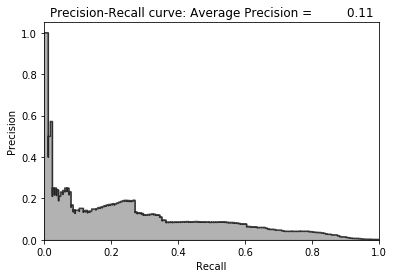

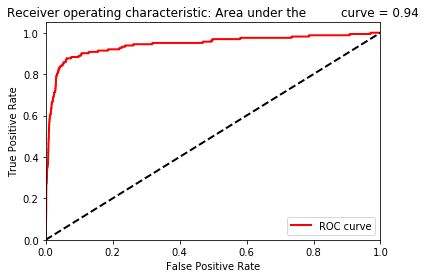

In [10]:
# Evaluate on test set
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.0844 - acc: 0.8901 - val_loss: 0.0016 - val_acc: 0.9889
Epoch 2/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.0022 - acc: 0.9852 - val_loss: 8.7772e-04 - val_acc: 0.9888
Epoch 3/10
190820/190820 [==============================] - 10s 51us/step - loss: 9.9386e-04 - acc: 0.9916 - val_loss: 3.1922e-05 - val_acc: 0.9986
Epoch 4/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.0018 - acc: 0.9920 - val_loss: 0.0046 - val_acc: 0.9835
Epoch 5/10
190820/190820 [==============================] - 10s 52us/step - loss: 3.4671e-04 - acc: 0.9950 - val_loss: 1.6178e-07 - val_acc: 0.9998
Epoch 6/10
190820/190820 [==============================] - 10s 51us/step - loss: 7.7225e-04 - acc: 0.9936 - val_loss: 1.5316e-04 - val_acc: 0.9965
Epoch 7/10
190820/190820 [==============================] - 11s 55us/step - loss

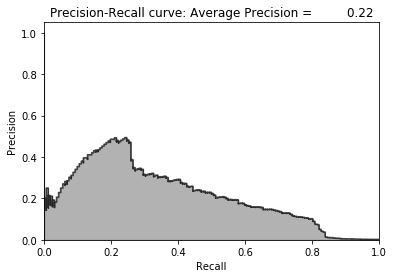

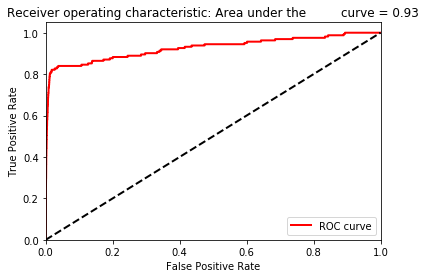

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0840 - acc: 0.8919 - val_loss: 3.3403e-04 - val_acc: 0.9937
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 6.5433e-04 - acc: 0.9930 - val_loss: 3.7562e-04 - val_acc: 0.9956
Epoch 3/10
190820/190820 [==============================] - 10s 54us/step - loss: 6.0375e-04 - acc: 0.9939 - val_loss: 5.6780e-07 - val_acc: 0.9996
Epoch 4/10
190820/190820 [==============================] - 10s 52us/step - loss: 8.1757e-04 - acc: 0.9930 - val_loss: 0.0031 - val_acc: 0.9798
Epoch 5/10
190820/190820 [==============================] - 10s 52us/step - loss: 4.7055e-04 - acc: 0.9950 - val_loss: 0.0145 - val_acc: 0.9686
Epoch 6/10
190820/190820 [==============================] - 10s 51us/step - loss: 5.4971e-04 - acc: 0.9958 - val_loss: 0.0016 - val_acc: 0.9776
Epoch 7/10
190820/190820 [==============================] - 10s 51us/step - 

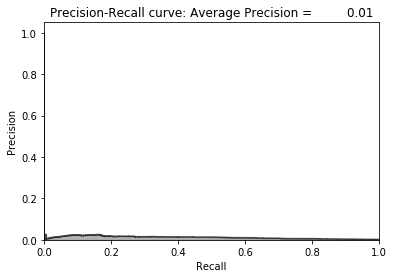

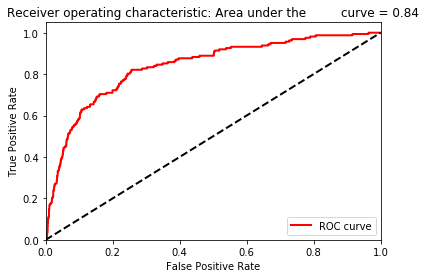

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.0801 - acc: 0.8992 - val_loss: 0.0013 - val_acc: 0.9898
Epoch 2/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.0011 - acc: 0.9907 - val_loss: 3.5783e-05 - val_acc: 0.9970
Epoch 3/10
190820/190820 [==============================] - 10s 53us/step - loss: 6.8039e-04 - acc: 0.9935 - val_loss: 5.7882e-04 - val_acc: 0.9903
Epoch 4/10
190820/190820 [==============================] - 10s 53us/step - loss: 5.8510e-04 - acc: 0.9936 - val_loss: 2.1843e-05 - val_acc: 0.9972
Epoch 5/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.0011 - acc: 0.9933 - val_loss: 1.8875e-05 - val_acc: 0.9981
Epoch 6/10
190820/190820 [==============================] - 10s 52us/step - loss: 3.1602e-04 - acc: 0.9956 - val_loss: 1.6010e-06 - val_acc: 0.9994
Epoch 7/10
190820/190820 [==============================] - 10s 52us/step - 

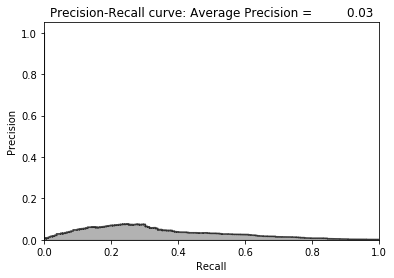

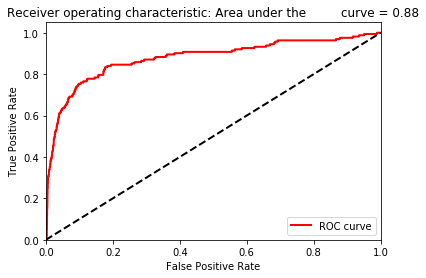

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.0973 - acc: 0.8926 - val_loss: 0.0014 - val_acc: 0.9895
Epoch 2/10
190820/190820 [==============================] - 10s 53us/step - loss: 7.5914e-04 - acc: 0.9918 - val_loss: 2.5392e-06 - val_acc: 0.9994
Epoch 3/10
190820/190820 [==============================] - 10s 53us/step - loss: 6.1462e-04 - acc: 0.9940 - val_loss: 5.8210e-05 - val_acc: 0.9971
Epoch 4/10
190820/190820 [==============================] - 10s 55us/step - loss: 6.8202e-04 - acc: 0.9946 - val_loss: 3.8658e-05 - val_acc: 0.9977
Epoch 5/10
190820/190820 [==============================] - 10s 53us/step - loss: 4.5397e-04 - acc: 0.9949 - val_loss: 3.2155e-07 - val_acc: 0.9996
Epoch 6/10
190820/190820 [==============================] - 10s 55us/step - loss: 8.6683e-04 - acc: 0.9936 - val_loss: 3.3972e-08 - val_acc: 0.9999
Epoch 7/10
190820/190820 [==============================] - 11s 59us

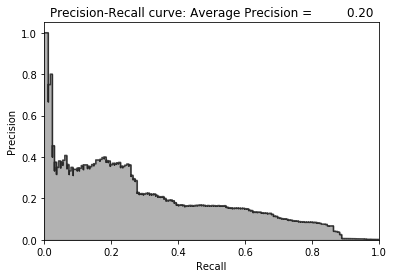

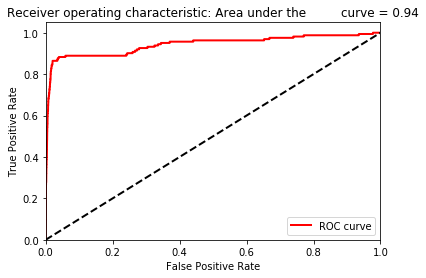

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0869 - acc: 0.8869 - val_loss: 8.1979e-04 - val_acc: 0.9916
Epoch 2/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.0011 - acc: 0.9907 - val_loss: 6.6646e-06 - val_acc: 0.9988
Epoch 3/10
190820/190820 [==============================] - 11s 56us/step - loss: 8.1072e-04 - acc: 0.9948 - val_loss: 2.3498e-08 - val_acc: 1.0000
Epoch 4/10
190820/190820 [==============================] - 10s 54us/step - loss: 6.8495e-04 - acc: 0.9941 - val_loss: 3.9392e-05 - val_acc: 0.9977
Epoch 5/10
190820/190820 [==============================] - 10s 54us/step - loss: 5.7639e-04 - acc: 0.9952 - val_loss: 0.0013 - val_acc: 0.9899
Epoch 6/10
190820/190820 [==============================] - 10s 54us/step - loss: 5.6285e-04 - acc: 0.9943 - val_loss: 1.2977e-05 - val_acc: 0.9990
Epoch 7/10
190820/190820 [==============================] - 11s 55us/ste

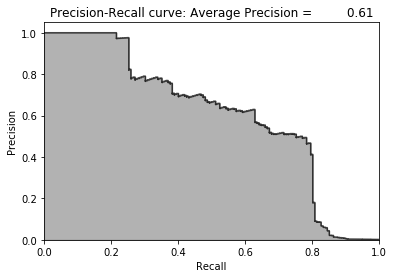

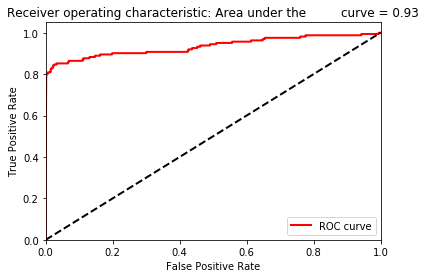

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0861 - acc: 0.8874 - val_loss: 0.0034 - val_acc: 0.9757
Epoch 2/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0011 - acc: 0.9900 - val_loss: 0.0020 - val_acc: 0.9727
Epoch 3/10
190820/190820 [==============================] - 11s 55us/step - loss: 9.3360e-04 - acc: 0.9940 - val_loss: 0.0015 - val_acc: 0.9780
Epoch 4/10
190820/190820 [==============================] - 10s 55us/step - loss: 5.5010e-04 - acc: 0.9946 - val_loss: 2.0206e-05 - val_acc: 0.9986
Epoch 5/10
190820/190820 [==============================] - 10s 55us/step - loss: 6.9472e-04 - acc: 0.9937 - val_loss: 9.4739e-10 - val_acc: 1.0000
Epoch 6/10
190820/190820 [==============================] - 10s 55us/step - loss: 9.2402e-04 - acc: 0.9935 - val_loss: 2.1218e-07 - val_acc: 0.9998
Epoch 7/10
190820/190820 [==============================] - 10s 55us/step - loss

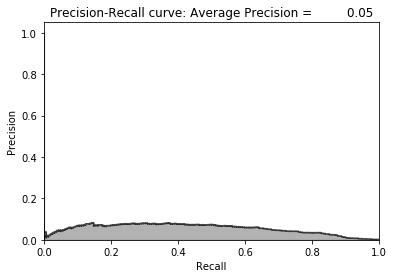

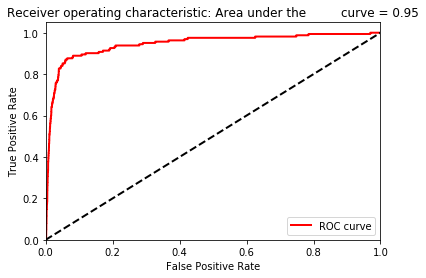

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.0905 - acc: 0.8888 - val_loss: 0.0022 - val_acc: 0.9842
Epoch 2/10
190820/190820 [==============================] - 11s 55us/step - loss: 0.0015 - acc: 0.9881 - val_loss: 1.2131e-04 - val_acc: 0.9976
Epoch 3/10
190820/190820 [==============================] - 10s 54us/step - loss: 7.6462e-04 - acc: 0.9934 - val_loss: 0.0023 - val_acc: 0.9865
Epoch 4/10
190820/190820 [==============================] - 10s 55us/step - loss: 5.7936e-04 - acc: 0.9949 - val_loss: 5.4458e-04 - val_acc: 0.9865
Epoch 5/10
190820/190820 [==============================] - 11s 55us/step - loss: 5.8743e-04 - acc: 0.9939 - val_loss: 0.0027 - val_acc: 0.9809
Epoch 6/10
190820/190820 [==============================] - 11s 56us/step - loss: 5.6635e-04 - acc: 0.9952 - val_loss: 1.6328e-05 - val_acc: 0.9977
Epoch 7/10
190820/190820 [==============================] - 11s 55us/step - loss

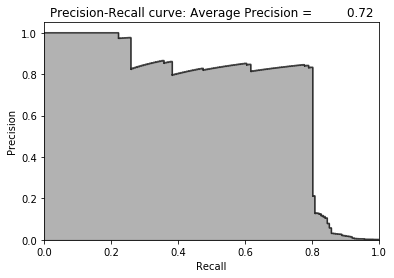

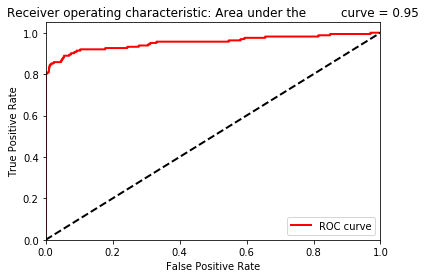

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.0792 - acc: 0.8993 - val_loss: 0.0016 - val_acc: 0.9912
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.0017 - acc: 0.9887 - val_loss: 1.0102e-05 - val_acc: 0.9991
Epoch 3/10
190820/190820 [==============================] - 11s 56us/step - loss: 6.0795e-04 - acc: 0.9956 - val_loss: 1.4300e-08 - val_acc: 0.9999
Epoch 4/10
190820/190820 [==============================] - 11s 55us/step - loss: 7.8528e-04 - acc: 0.9944 - val_loss: 2.8257e-06 - val_acc: 0.9994
Epoch 5/10
190820/190820 [==============================] - 10s 55us/step - loss: 5.4362e-04 - acc: 0.9955 - val_loss: 8.7600e-07 - val_acc: 0.9997
Epoch 6/10
190820/190820 [==============================] - 11s 56us/step - loss: 5.4554e-04 - acc: 0.9943 - val_loss: 3.0961e-06 - val_acc: 0.9993
Epoch 7/10
190820/190820 [==============================] - 10s 55us/ste

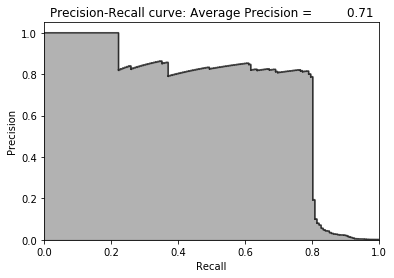

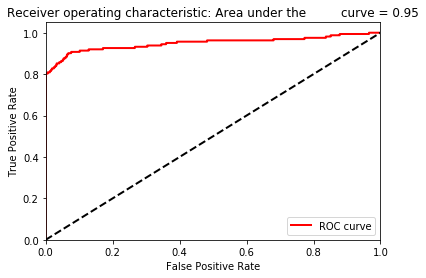

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0730 - acc: 0.9012 - val_loss: 0.0018 - val_acc: 0.9870
Epoch 2/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.0017 - acc: 0.9878 - val_loss: 2.4507e-05 - val_acc: 0.9986
Epoch 3/10
190820/190820 [==============================] - 11s 56us/step - loss: 4.9434e-04 - acc: 0.9953 - val_loss: 1.8323e-04 - val_acc: 0.9945
Epoch 4/10
190820/190820 [==============================] - 11s 56us/step - loss: 7.6386e-04 - acc: 0.9930 - val_loss: 3.8009e-04 - val_acc: 0.9964
Epoch 5/10
190820/190820 [==============================] - 11s 56us/step - loss: 4.6234e-04 - acc: 0.9938 - val_loss: 2.0209e-04 - val_acc: 0.9946
Epoch 6/10
190820/190820 [==============================] - 11s 56us/step - loss: 5.1280e-04 - acc: 0.9945 - val_loss: 5.7453e-09 - val_acc: 1.0000
Epoch 7/10
190820/190820 [==============================] - 11s 56us/ste

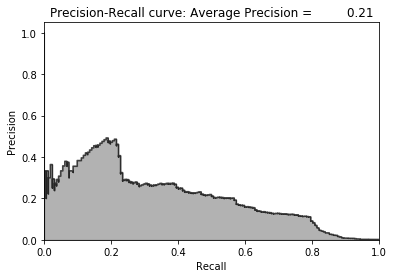

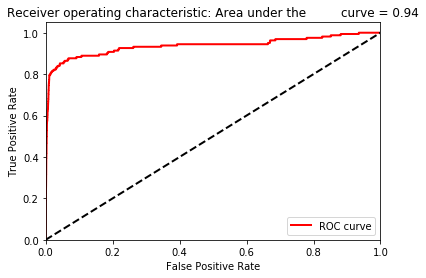

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.0856 - acc: 0.8848 - val_loss: 0.0014 - val_acc: 0.9869
Epoch 2/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.0017 - acc: 0.9882 - val_loss: 1.3527e-05 - val_acc: 0.9987
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 6.1035e-04 - acc: 0.9941 - val_loss: 1.1904e-04 - val_acc: 0.9947
Epoch 4/10
190820/190820 [==============================] - 11s 59us/step - loss: 5.3451e-04 - acc: 0.9937 - val_loss: 2.6372e-04 - val_acc: 0.9908
Epoch 5/10
190820/190820 [==============================] - 11s 57us/step - loss: 5.4179e-04 - acc: 0.9942 - val_loss: 9.1680e-05 - val_acc: 0.9967
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 4.2086e-04 - acc: 0.9947 - val_loss: 0.0015 - val_acc: 0.9717
Epoch 7/10
190820/190820 [==============================] - 11s 57us/step - 

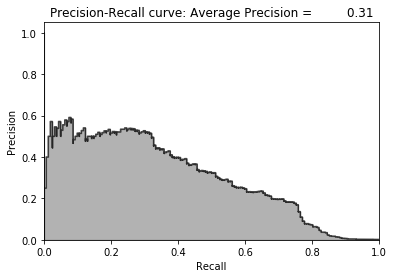

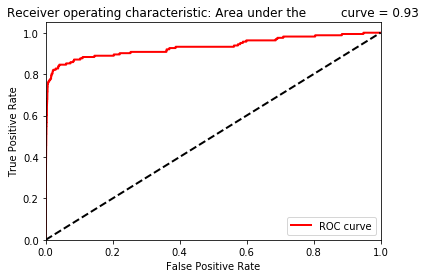

Mean average precision over 10 runs:  0.3069490587964295


[0.2163664536692818,
 0.011688151218975177,
 0.031827036321013524,
 0.20064149527776692,
 0.6107238831092416,
 0.05413334039582606,
 0.7200481137294686,
 0.7086773079860293,
 0.2100091472438929,
 0.3053756590127983]

In [11]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [12]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.3069490587964295
Coefficient of variation over 10 runs:  0.8495539477981069


[0.2163664536692818,
 0.011688151218975177,
 0.031827036321013524,
 0.20064149527776692,
 0.6107238831092416,
 0.05413334039582606,
 0.7200481137294686,
 0.7086773079860293,
 0.2100091472438929,
 0.3053756590127983]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.3428 - acc: 0.5526 - val_loss: 0.2798 - val_acc: 0.5806
Epoch 2/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2850 - acc: 0.5898 - val_loss: 0.2773 - val_acc: 0.5956
Epoch 3/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2808 - acc: 0.6009 - val_loss: 0.2757 - val_acc: 0.6016
Epoch 4/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2791 - acc: 0.6098 - val_loss: 0.2752 - val_acc: 0.6076
Epoch 5/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2785 - acc: 0.6075 - val_loss: 0.2747 - val_acc: 0.6096
Epoch 6/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2770 - acc: 0.6012 - val_loss: 0.2749 - val_acc: 0.6136
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2779 - acc: 0.6125 - val

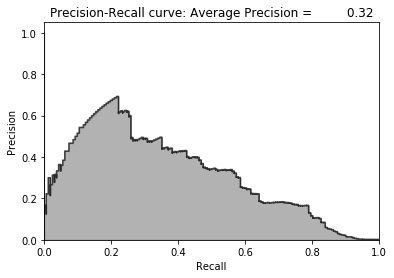

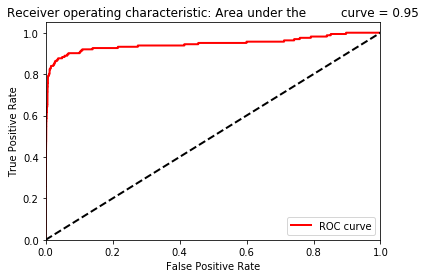

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.3660 - acc: 0.5573 - val_loss: 0.2790 - val_acc: 0.5872
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2825 - acc: 0.6158 - val_loss: 0.2766 - val_acc: 0.6107
Epoch 3/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2815 - acc: 0.6248 - val_loss: 0.2761 - val_acc: 0.6228
Epoch 4/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2793 - acc: 0.6129 - val_loss: 0.2755 - val_acc: 0.6174
Epoch 5/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2786 - acc: 0.6190 - val_loss: 0.2752 - val_acc: 0.6209
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2769 - acc: 0.6137 - val_loss: 0.2757 - val_acc: 0.6112
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2779 - acc: 0.6131 - val

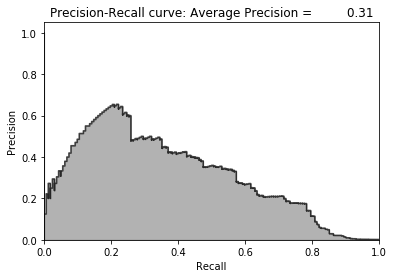

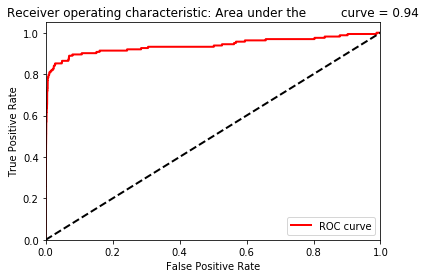

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.3476 - acc: 0.5358 - val_loss: 0.2837 - val_acc: 0.6133
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2799 - acc: 0.6179 - val_loss: 0.2764 - val_acc: 0.6110
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2807 - acc: 0.6129 - val_loss: 0.2757 - val_acc: 0.6154
Epoch 4/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2791 - acc: 0.6165 - val_loss: 0.2761 - val_acc: 0.6133
Epoch 5/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2787 - acc: 0.6317 - val_loss: 0.2749 - val_acc: 0.6191
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2785 - acc: 0.6149 - val_loss: 0.2759 - val_acc: 0.6232
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2783 - acc: 0.6261 - val

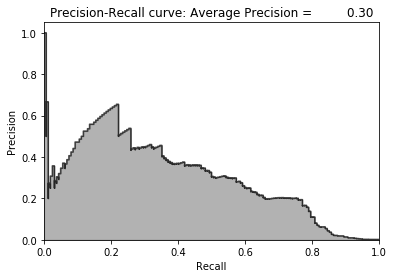

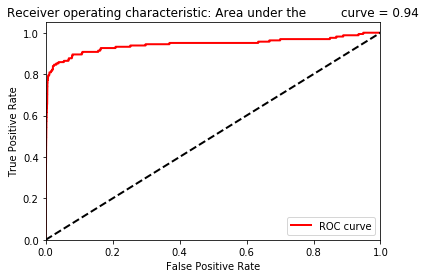

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.3367 - acc: 0.5451 - val_loss: 0.2786 - val_acc: 0.5881
Epoch 2/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2824 - acc: 0.5776 - val_loss: 0.2766 - val_acc: 0.5690
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2797 - acc: 0.5543 - val_loss: 0.2764 - val_acc: 0.5626
Epoch 4/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2791 - acc: 0.5763 - val_loss: 0.2753 - val_acc: 0.5716
Epoch 5/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2775 - acc: 0.5643 - val_loss: 0.2763 - val_acc: 0.5758
Epoch 6/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2789 - acc: 0.5905 - val_loss: 0.2752 - val_acc: 0.5886
Epoch 7/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2784 - acc: 0.5884 - val

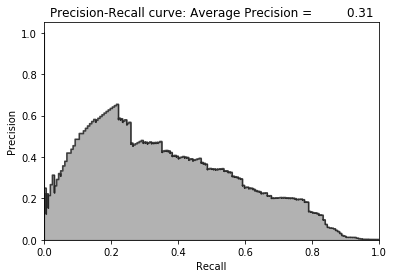

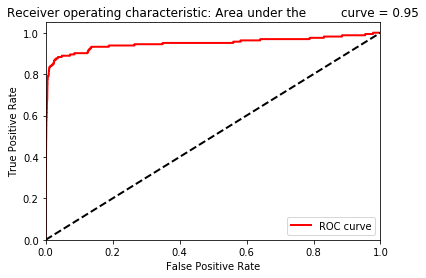

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.3633 - acc: 0.5385 - val_loss: 0.2799 - val_acc: 0.5868
Epoch 2/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2828 - acc: 0.6009 - val_loss: 0.2765 - val_acc: 0.6011
Epoch 3/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2800 - acc: 0.6039 - val_loss: 0.2756 - val_acc: 0.5967
Epoch 4/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2787 - acc: 0.5885 - val_loss: 0.2752 - val_acc: 0.5891
Epoch 5/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2777 - acc: 0.5905 - val_loss: 0.2751 - val_acc: 0.5847
Epoch 6/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2781 - acc: 0.5871 - val_loss: 0.2760 - val_acc: 0.5873
Epoch 7/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2776 - acc: 0.5867 - val

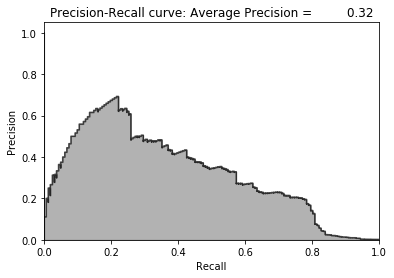

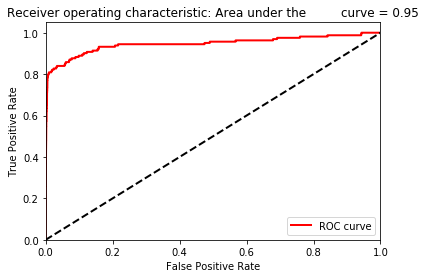

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.3533 - acc: 0.5617 - val_loss: 0.2779 - val_acc: 0.5977
Epoch 2/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2821 - acc: 0.6104 - val_loss: 0.2764 - val_acc: 0.5995
Epoch 3/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2795 - acc: 0.5863 - val_loss: 0.2754 - val_acc: 0.5876
Epoch 4/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2777 - acc: 0.5952 - val_loss: 0.2755 - val_acc: 0.5922
Epoch 5/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2786 - acc: 0.5964 - val_loss: 0.2746 - val_acc: 0.5999
Epoch 6/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2771 - acc: 0.6024 - val_loss: 0.2750 - val_acc: 0.6041
Epoch 7/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2773 - acc: 0.6142 - val

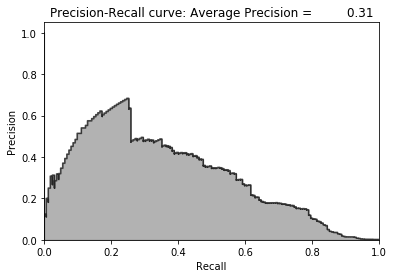

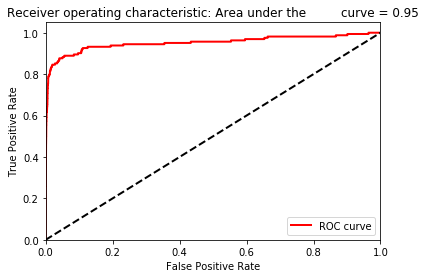

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.3536 - acc: 0.5598 - val_loss: 0.2794 - val_acc: 0.5869
Epoch 2/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2826 - acc: 0.5832 - val_loss: 0.2797 - val_acc: 0.6081
Epoch 3/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2806 - acc: 0.6209 - val_loss: 0.2767 - val_acc: 0.6241
Epoch 4/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2785 - acc: 0.6179 - val_loss: 0.2759 - val_acc: 0.6161
Epoch 5/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2796 - acc: 0.6034 - val_loss: 0.2750 - val_acc: 0.6051
Epoch 6/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2778 - acc: 0.6061 - val_loss: 0.2755 - val_acc: 0.6057
Epoch 7/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2784 - acc: 0.5926 - val

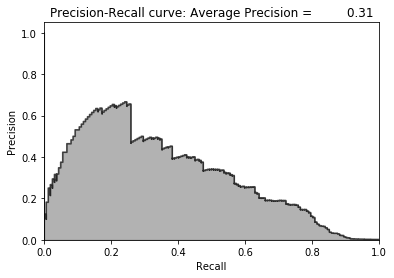

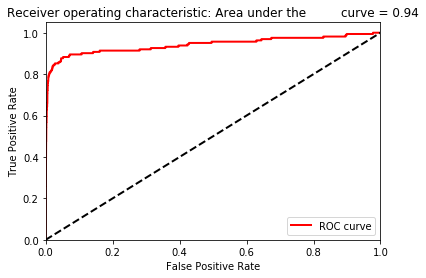

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.3285 - acc: 0.5924 - val_loss: 0.2790 - val_acc: 0.6160
Epoch 2/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2830 - acc: 0.6218 - val_loss: 0.2779 - val_acc: 0.6185
Epoch 3/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.2815 - acc: 0.6206 - val_loss: 0.2761 - val_acc: 0.6220
Epoch 4/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2791 - acc: 0.6144 - val_loss: 0.2753 - val_acc: 0.6079
Epoch 5/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2792 - acc: 0.6077 - val_loss: 0.2750 - val_acc: 0.5993
Epoch 6/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2781 - acc: 0.5971 - val_loss: 0.2746 - val_acc: 0.5937
Epoch 7/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.2777 - acc: 0.5858 - val

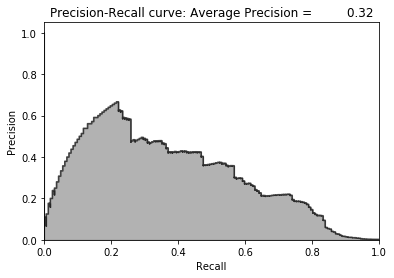

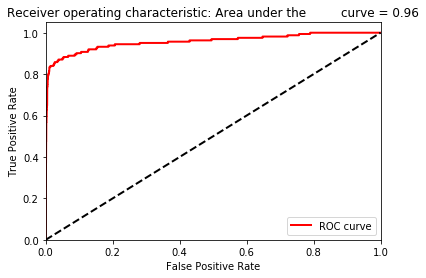

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 71us/step - loss: 0.3439 - acc: 0.5597 - val_loss: 0.2787 - val_acc: 0.5870
Epoch 2/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.2826 - acc: 0.5904 - val_loss: 0.2766 - val_acc: 0.5979
Epoch 3/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2815 - acc: 0.6059 - val_loss: 0.2767 - val_acc: 0.5956
Epoch 4/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2795 - acc: 0.5869 - val_loss: 0.2769 - val_acc: 0.5919
Epoch 5/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2793 - acc: 0.5791 - val_loss: 0.2752 - val_acc: 0.5894
Epoch 6/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2784 - acc: 0.5874 - val_loss: 0.2752 - val_acc: 0.5962
Epoch 7/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2780 - acc: 0.5868 - val

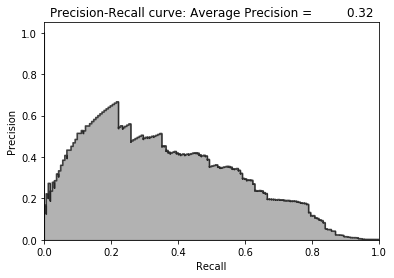

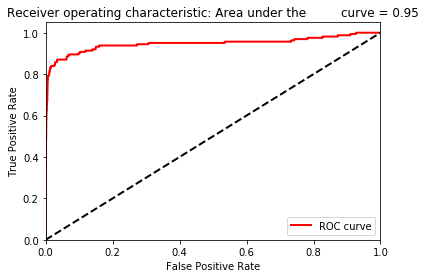

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.3356 - acc: 0.5470 - val_loss: 0.2783 - val_acc: 0.5931
Epoch 2/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.2818 - acc: 0.5934 - val_loss: 0.2765 - val_acc: 0.5848
Epoch 3/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2791 - acc: 0.5803 - val_loss: 0.2765 - val_acc: 0.5939
Epoch 4/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2790 - acc: 0.5854 - val_loss: 0.2754 - val_acc: 0.5902
Epoch 5/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2782 - acc: 0.5967 - val_loss: 0.2746 - val_acc: 0.5888
Epoch 6/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2775 - acc: 0.5896 - val_loss: 0.2751 - val_acc: 0.5883
Epoch 7/10
190820/190820 [==============================] - 12s 62us/step - loss: 0.2780 - acc: 0.5890 - val

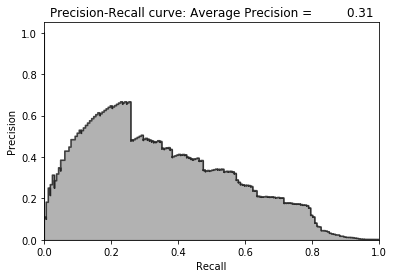

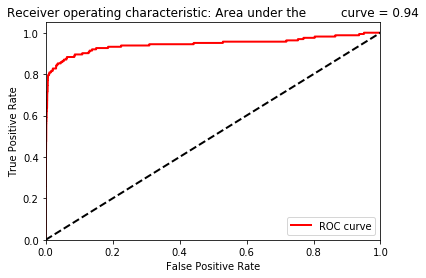

Mean average precision over 10 runs:  0.31396112848756874


[0.3163980878698543,
 0.31270954315163163,
 0.3028090422503941,
 0.31100221369179387,
 0.32242014412332426,
 0.3123831803603172,
 0.31382684490361523,
 0.316829300783763,
 0.3179376990890407,
 0.31329522865195314]

In [13]:
# Model two
# Two layer undercomplete autoencoder with linear activation
# With 20 nodes in hidden layer

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [14]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.31396112848756874
Coefficient of variation over 10 runs:  0.015576944447035456


[0.3163980878698543,
 0.31270954315163163,
 0.3028090422503941,
 0.31100221369179387,
 0.32242014412332426,
 0.3123831803603172,
 0.31382684490361523,
 0.316829300783763,
 0.3179376990890407,
 0.31329522865195314]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.1656 - acc: 0.7778 - val_loss: 0.0368 - val_acc: 0.8929
Epoch 2/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0388 - acc: 0.9017 - val_loss: 0.0352 - val_acc: 0.9058
Epoch 3/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0383 - acc: 0.9244 - val_loss: 0.0349 - val_acc: 0.9244
Epoch 4/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0371 - acc: 0.9340 - val_loss: 0.0349 - val_acc: 0.9407
Epoch 5/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0359 - acc: 0.9532 - val_loss: 0.0360 - val_acc: 0.9310
Epoch 6/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0356 - acc: 0.9454 - val_loss: 0.0344 - val_acc: 0.9454
Epoch 7/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0355 - acc: 0.9548 - val

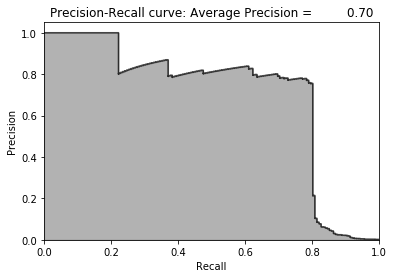

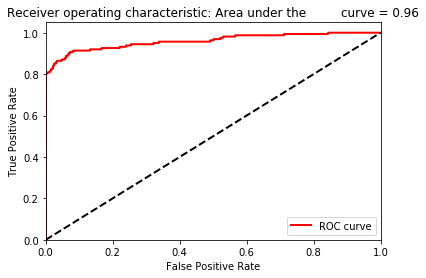

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.1189 - acc: 0.8326 - val_loss: 0.0562 - val_acc: 0.8522
Epoch 2/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0391 - acc: 0.8907 - val_loss: 0.0362 - val_acc: 0.8841
Epoch 3/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0373 - acc: 0.8953 - val_loss: 0.0368 - val_acc: 0.8994
Epoch 4/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0392 - acc: 0.9125 - val_loss: 0.0354 - val_acc: 0.9152
Epoch 5/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0377 - acc: 0.9192 - val_loss: 0.0360 - val_acc: 0.9306
Epoch 6/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0376 - acc: 0.9333 - val_loss: 0.0355 - val_acc: 0.9205
Epoch 7/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0369 - acc: 0.9345 - val

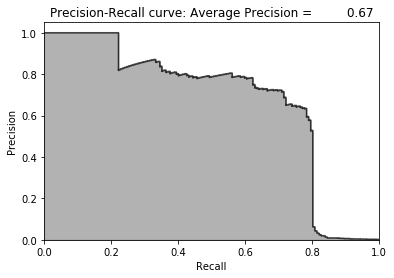

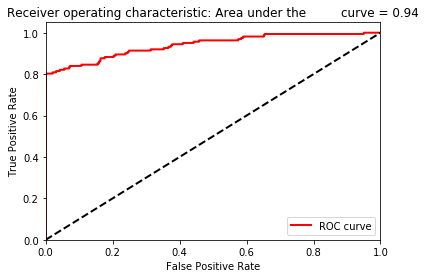

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.1602 - acc: 0.7843 - val_loss: 0.0370 - val_acc: 0.8769
Epoch 2/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0414 - acc: 0.9152 - val_loss: 0.0422 - val_acc: 0.9423
Epoch 3/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0397 - acc: 0.9491 - val_loss: 0.0385 - val_acc: 0.9518
Epoch 4/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0389 - acc: 0.9575 - val_loss: 0.0372 - val_acc: 0.9642
Epoch 5/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.0387 - acc: 0.9623 - val_loss: 0.0368 - val_acc: 0.9668
Epoch 6/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0382 - acc: 0.9601 - val_loss: 0.0374 - val_acc: 0.9602
Epoch 7/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0390 - acc: 0.9593 - val

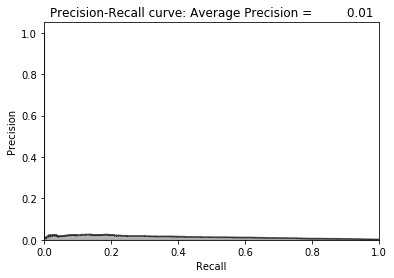

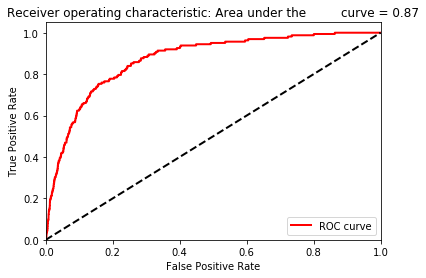

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 13s 71us/step - loss: 0.1312 - acc: 0.8214 - val_loss: 0.0369 - val_acc: 0.9146
Epoch 2/10
190820/190820 [==============================] - 13s 69us/step - loss: 0.0406 - acc: 0.9284 - val_loss: 0.0358 - val_acc: 0.9290
Epoch 3/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0378 - acc: 0.9185 - val_loss: 0.0359 - val_acc: 0.9334
Epoch 4/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0376 - acc: 0.9340 - val_loss: 0.0354 - val_acc: 0.9302
Epoch 5/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0368 - acc: 0.9363 - val_loss: 0.0345 - val_acc: 0.9392
Epoch 6/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0363 - acc: 0.9386 - val_loss: 0.0347 - val_acc: 0.9396
Epoch 7/10
190820/190820 [==============================] - 12s 64us/step - loss: 0.0354 - acc: 0.9361 - val

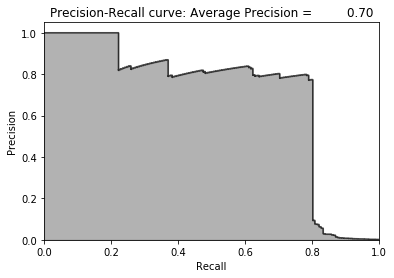

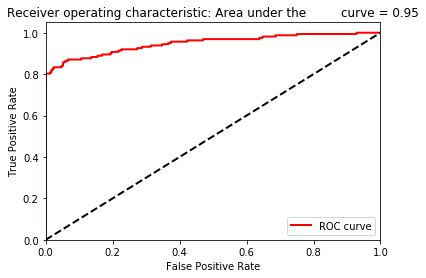

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.1117 - acc: 0.8507 - val_loss: 0.0363 - val_acc: 0.9309
Epoch 2/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0390 - acc: 0.9238 - val_loss: 0.0366 - val_acc: 0.9429
Epoch 3/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0402 - acc: 0.9487 - val_loss: 0.0365 - val_acc: 0.9573
Epoch 4/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0386 - acc: 0.9573 - val_loss: 0.0374 - val_acc: 0.9666
Epoch 5/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0392 - acc: 0.9599 - val_loss: 0.0378 - val_acc: 0.9585
Epoch 6/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0379 - acc: 0.9656 - val_loss: 0.0377 - val_acc: 0.9630
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0393 - acc: 0.9629 - val

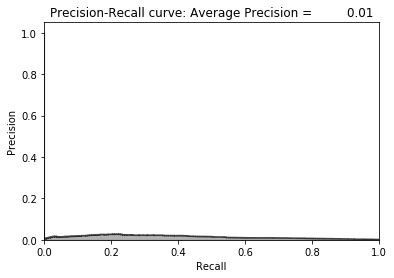

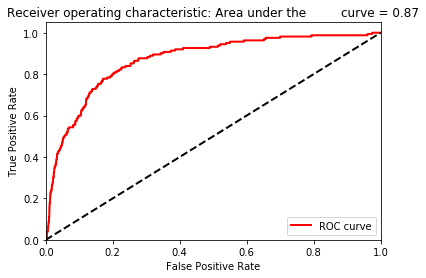

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.1156 - acc: 0.7854 - val_loss: 0.0380 - val_acc: 0.8891
Epoch 2/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0397 - acc: 0.9187 - val_loss: 0.0382 - val_acc: 0.9377
Epoch 3/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0393 - acc: 0.9428 - val_loss: 0.0368 - val_acc: 0.9521
Epoch 4/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0396 - acc: 0.9561 - val_loss: 0.0377 - val_acc: 0.9591
Epoch 5/10
190820/190820 [==============================] - 12s 65us/step - loss: 0.0390 - acc: 0.9571 - val_loss: 0.0368 - val_acc: 0.9601
Epoch 6/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0389 - acc: 0.9569 - val_loss: 0.0369 - val_acc: 0.9600
Epoch 7/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0393 - acc: 0.9549 - val

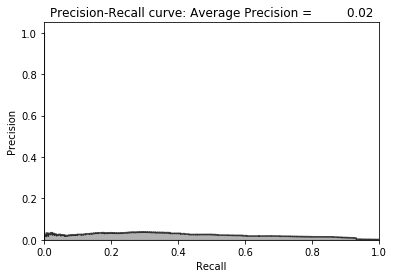

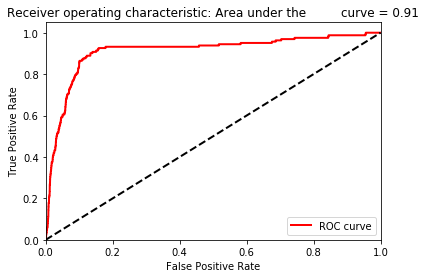

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.1381 - acc: 0.8123 - val_loss: 0.0367 - val_acc: 0.9076
Epoch 2/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0390 - acc: 0.9229 - val_loss: 0.0365 - val_acc: 0.9304
Epoch 3/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0381 - acc: 0.9348 - val_loss: 0.0362 - val_acc: 0.9401
Epoch 4/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0392 - acc: 0.9437 - val_loss: 0.0362 - val_acc: 0.9481
Epoch 5/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0384 - acc: 0.9493 - val_loss: 0.0364 - val_acc: 0.9533
Epoch 6/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0395 - acc: 0.9486 - val_loss: 0.0367 - val_acc: 0.9545
Epoch 7/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0388 - acc: 0.9540 - val

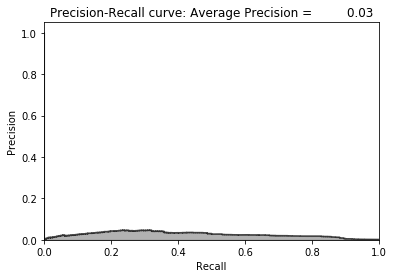

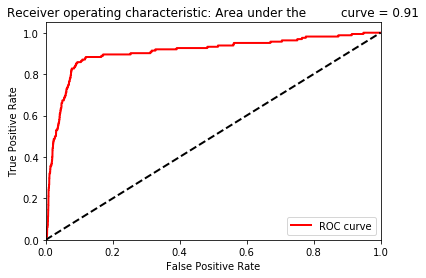

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.1066 - acc: 0.8317 - val_loss: 0.0360 - val_acc: 0.8937
Epoch 2/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0380 - acc: 0.9108 - val_loss: 0.0351 - val_acc: 0.9190
Epoch 3/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0372 - acc: 0.9189 - val_loss: 0.0344 - val_acc: 0.9332
Epoch 4/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0358 - acc: 0.9375 - val_loss: 0.0367 - val_acc: 0.9523
Epoch 5/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0349 - acc: 0.9553 - val_loss: 0.0349 - val_acc: 0.9366
Epoch 6/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0350 - acc: 0.9572 - val_loss: 0.0356 - val_acc: 0.9260
Epoch 7/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0369 - acc: 0.9407 - val

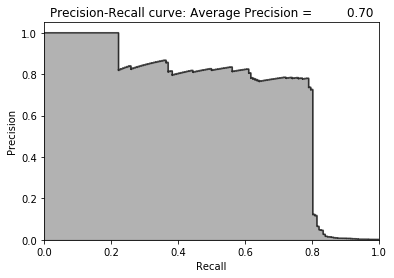

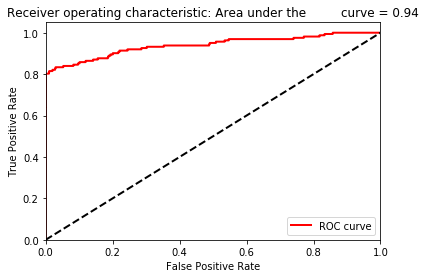

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.1153 - acc: 0.8160 - val_loss: 0.0371 - val_acc: 0.8787
Epoch 2/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0373 - acc: 0.8714 - val_loss: 0.0377 - val_acc: 0.9220
Epoch 3/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0400 - acc: 0.9358 - val_loss: 0.0375 - val_acc: 0.9419
Epoch 4/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0398 - acc: 0.9413 - val_loss: 0.0367 - val_acc: 0.9454
Epoch 5/10
190820/190820 [==============================] - 13s 66us/step - loss: 0.0403 - acc: 0.9523 - val_loss: 0.0372 - val_acc: 0.9490
Epoch 6/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0391 - acc: 0.9490 - val_loss: 0.0366 - val_acc: 0.9517
Epoch 7/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0383 - acc: 0.9495 - val

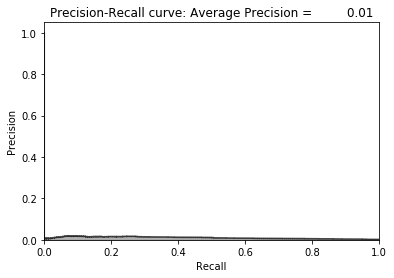

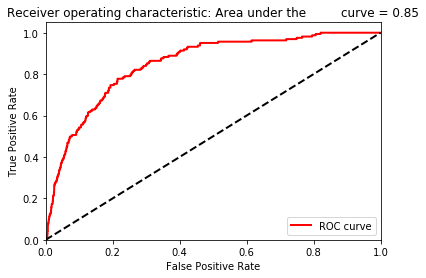

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.1292 - acc: 0.7920 - val_loss: 0.0724 - val_acc: 0.8490
Epoch 2/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0367 - acc: 0.9088 - val_loss: 0.0349 - val_acc: 0.9255
Epoch 3/10
190820/190820 [==============================] - 13s 68us/step - loss: 0.0365 - acc: 0.9429 - val_loss: 0.0344 - val_acc: 0.9430
Epoch 4/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0352 - acc: 0.9456 - val_loss: 0.0339 - val_acc: 0.9645
Epoch 5/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0354 - acc: 0.9517 - val_loss: 0.0338 - val_acc: 0.9746
Epoch 6/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0353 - acc: 0.9607 - val_loss: 0.0345 - val_acc: 0.9698
Epoch 7/10
190820/190820 [==============================] - 13s 67us/step - loss: 0.0357 - acc: 0.9449 - val

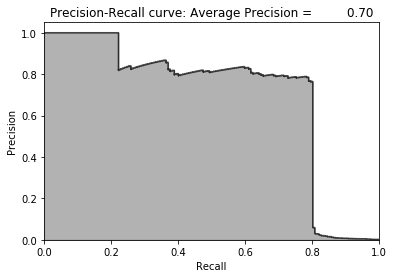

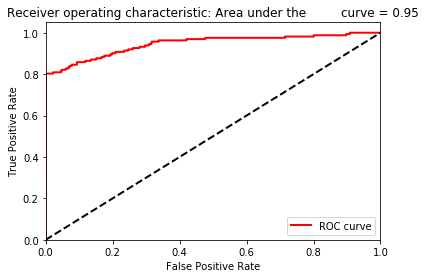

Mean average precision over 10 runs:  0.35529735634118015


[0.7000193201140985,
 0.6723950402633658,
 0.01351107721889969,
 0.6995066261318598,
 0.014083724350662704,
 0.02301627017708498,
 0.02555388114719097,
 0.696627568432957,
 0.01029099220092642,
 0.6979690633747557]

In [15]:
# Model two v2
# Two layer undercomplete autoencoder with linear activation
# With 27 nodes this time

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [16]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.35529735634118015
Coefficient of variation over 10 runs:  0.9516363198023807


[0.7000193201140985,
 0.6723950402633658,
 0.01351107721889969,
 0.6995066261318598,
 0.014083724350662704,
 0.02301627017708498,
 0.02555388114719097,
 0.696627568432957,
 0.01029099220092642,
 0.6979690633747557]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.1252 - acc: 0.7940 - val_loss: 0.0387 - val_acc: 0.8833
Epoch 2/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0385 - acc: 0.8813 - val_loss: 0.0371 - val_acc: 0.9088
Epoch 3/10
190820/190820 [==============================] - 13s 71us/step - loss: 0.0404 - acc: 0.9163 - val_loss: 0.0402 - val_acc: 0.9268
Epoch 4/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0400 - acc: 0.9376 - val_loss: 0.0382 - val_acc: 0.9425
Epoch 5/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0396 - acc: 0.9466 - val_loss: 0.0392 - val_acc: 0.9564
Epoch 6/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0397 - acc: 0.9559 - val_loss: 0.0421 - val_acc: 0.9370
Epoch 7/10
190820/190820 [==============================] - 13s 70us/step - loss: 0.0395 - acc: 0.9578 - val

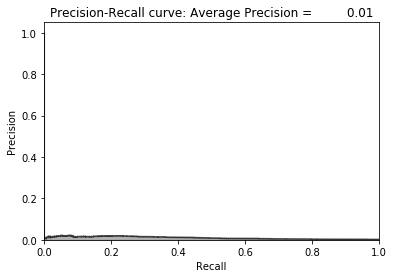

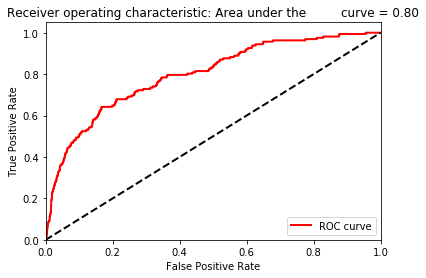

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.1212 - acc: 0.8264 - val_loss: 0.0369 - val_acc: 0.9230
Epoch 2/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0391 - acc: 0.9230 - val_loss: 0.0381 - val_acc: 0.9147
Epoch 3/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0388 - acc: 0.9101 - val_loss: 0.0360 - val_acc: 0.9184
Epoch 4/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0402 - acc: 0.9289 - val_loss: 0.0366 - val_acc: 0.9364
Epoch 5/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0398 - acc: 0.9394 - val_loss: 0.0368 - val_acc: 0.9451
Epoch 6/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0395 - acc: 0.9517 - val_loss: 0.0382 - val_acc: 0.9479
Epoch 7/10
190820/190820 [==============================] - 14s 71us/step - loss: 0.0393 - acc: 0.9576 - val

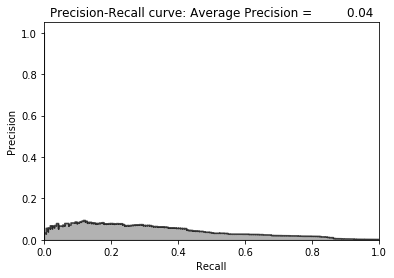

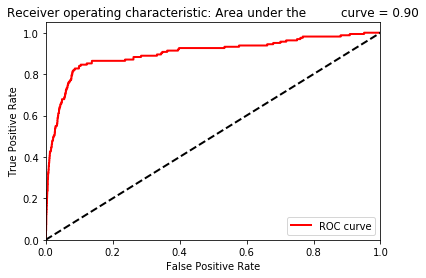

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.1118 - acc: 0.7835 - val_loss: 0.0365 - val_acc: 0.8569
Epoch 2/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0413 - acc: 0.8848 - val_loss: 0.0371 - val_acc: 0.9181
Epoch 3/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0390 - acc: 0.9204 - val_loss: 0.0422 - val_acc: 0.9267
Epoch 4/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0402 - acc: 0.9350 - val_loss: 0.0366 - val_acc: 0.9497
Epoch 5/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0395 - acc: 0.9532 - val_loss: 0.0428 - val_acc: 0.9411
Epoch 6/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0389 - acc: 0.9511 - val_loss: 0.0366 - val_acc: 0.9648
Epoch 7/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0389 - acc: 0.9564 - val

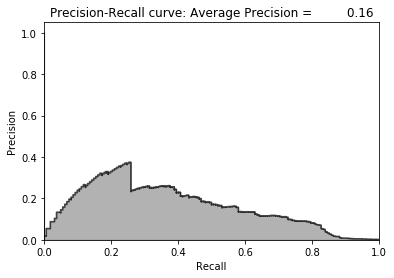

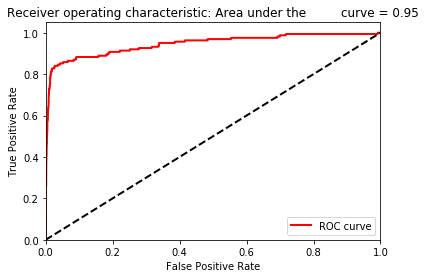

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 15s 80us/step - loss: 0.1364 - acc: 0.7356 - val_loss: 0.0356 - val_acc: 0.8504
Epoch 2/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0412 - acc: 0.8868 - val_loss: 0.0363 - val_acc: 0.9078
Epoch 3/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0383 - acc: 0.9089 - val_loss: 0.0359 - val_acc: 0.9145
Epoch 4/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0395 - acc: 0.9166 - val_loss: 0.0357 - val_acc: 0.9223
Epoch 5/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0396 - acc: 0.9301 - val_loss: 0.0367 - val_acc: 0.9127
Epoch 6/10
190820/190820 [==============================] - 14s 72us/step - loss: 0.0378 - acc: 0.9191 - val_loss: 0.0360 - val_acc: 0.9347
Epoch 7/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0391 - acc: 0.9366 - val

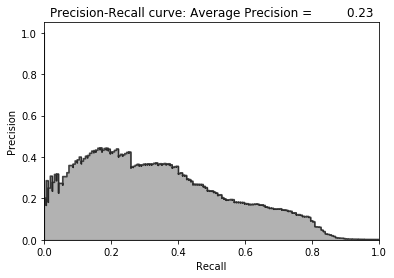

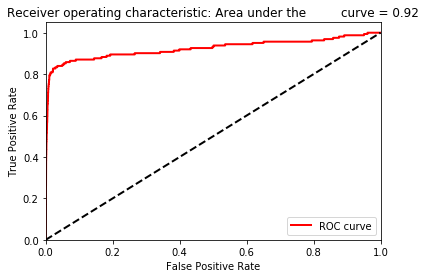

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.1286 - acc: 0.8072 - val_loss: 0.0378 - val_acc: 0.8881
Epoch 2/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0398 - acc: 0.8714 - val_loss: 0.0362 - val_acc: 0.8833
Epoch 3/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0421 - acc: 0.9146 - val_loss: 0.0365 - val_acc: 0.9369
Epoch 4/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0375 - acc: 0.9369 - val_loss: 0.0369 - val_acc: 0.9552
Epoch 5/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0401 - acc: 0.9528 - val_loss: 0.0364 - val_acc: 0.9541
Epoch 6/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0382 - acc: 0.9538 - val_loss: 0.0382 - val_acc: 0.9529
Epoch 7/10
190820/190820 [==============================] - 14s 73us/step - loss: 0.0392 - acc: 0.9526 - val

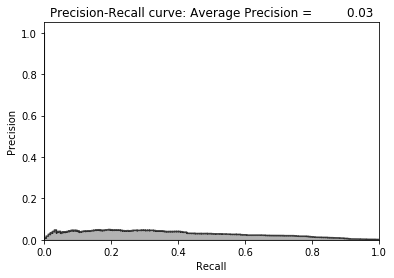

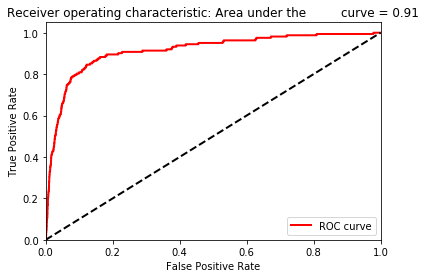

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.1489 - acc: 0.7617 - val_loss: 0.0394 - val_acc: 0.8861
Epoch 2/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0413 - acc: 0.9193 - val_loss: 0.0361 - val_acc: 0.9097
Epoch 3/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0398 - acc: 0.9238 - val_loss: 0.0366 - val_acc: 0.9299
Epoch 4/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0387 - acc: 0.9354 - val_loss: 0.0377 - val_acc: 0.9358
Epoch 5/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0397 - acc: 0.9396 - val_loss: 0.0366 - val_acc: 0.9189
Epoch 6/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0387 - acc: 0.9042 - val_loss: 0.0379 - val_acc: 0.9457
Epoch 7/10
190820/190820 [==============================] - 14s 74us/step - loss: 0.0404 - acc: 0.9482 - val

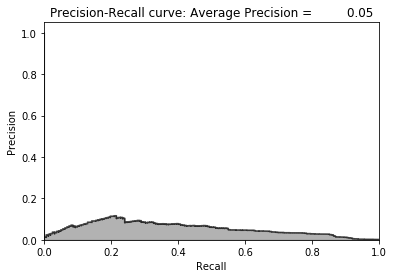

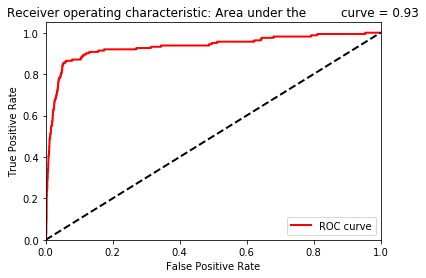

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.1403 - acc: 0.8088 - val_loss: 0.0379 - val_acc: 0.9223
Epoch 2/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0400 - acc: 0.9252 - val_loss: 0.0366 - val_acc: 0.9467
Epoch 3/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0402 - acc: 0.9569 - val_loss: 0.0371 - val_acc: 0.9637
Epoch 4/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0394 - acc: 0.9616 - val_loss: 0.0370 - val_acc: 0.9666
Epoch 5/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0393 - acc: 0.9643 - val_loss: 0.0368 - val_acc: 0.9656
Epoch 6/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0397 - acc: 0.9622 - val_loss: 0.0379 - val_acc: 0.9635
Epoch 7/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0389 - acc: 0.9641 - val

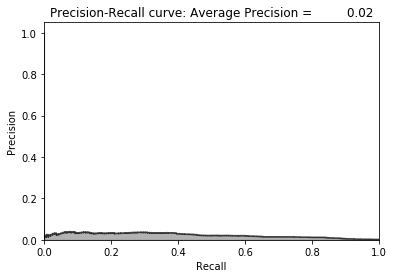

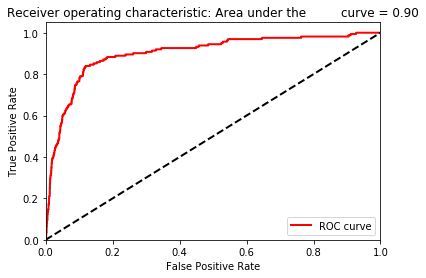

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.1118 - acc: 0.8242 - val_loss: 0.0368 - val_acc: 0.9182
Epoch 2/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0403 - acc: 0.9222 - val_loss: 0.0365 - val_acc: 0.9284
Epoch 3/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0400 - acc: 0.9195 - val_loss: 0.0371 - val_acc: 0.9400
Epoch 4/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0393 - acc: 0.9484 - val_loss: 0.0372 - val_acc: 0.9577
Epoch 5/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0394 - acc: 0.9509 - val_loss: 0.0372 - val_acc: 0.9486
Epoch 6/10
190820/190820 [==============================] - 14s 76us/step - loss: 0.0400 - acc: 0.9517 - val_loss: 0.0368 - val_acc: 0.9620
Epoch 7/10
190820/190820 [==============================] - 14s 75us/step - loss: 0.0392 - acc: 0.9560 - val

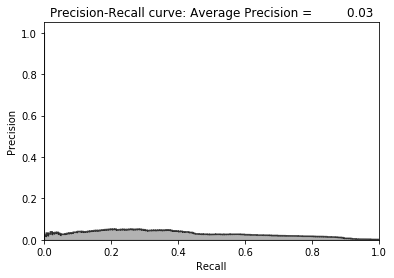

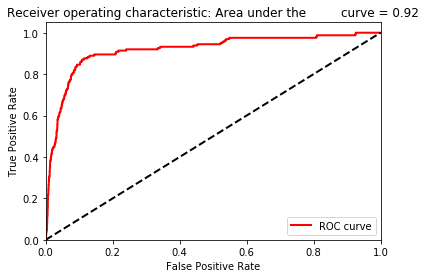

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.1122 - acc: 0.7998 - val_loss: 0.0421 - val_acc: 0.8682
Epoch 2/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0385 - acc: 0.9033 - val_loss: 0.0359 - val_acc: 0.9055
Epoch 3/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0388 - acc: 0.9212 - val_loss: 0.0371 - val_acc: 0.9221
Epoch 4/10
190820/190820 [==============================] - 15s 77us/step - loss: 0.0392 - acc: 0.9365 - val_loss: 0.0376 - val_acc: 0.9201
Epoch 5/10
190820/190820 [==============================] - 15s 76us/step - loss: 0.0380 - acc: 0.9325 - val_loss: 0.0372 - val_acc: 0.9318
Epoch 6/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0385 - acc: 0.9419 - val_loss: 0.0360 - val_acc: 0.9319
Epoch 7/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0378 - acc: 0.9305 - val

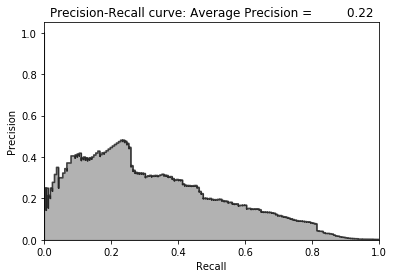

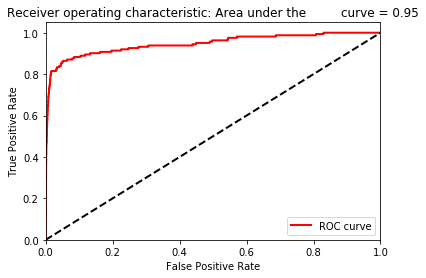

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.1190 - acc: 0.8331 - val_loss: 0.0965 - val_acc: 0.8552
Epoch 2/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0409 - acc: 0.9296 - val_loss: 0.0413 - val_acc: 0.9310
Epoch 3/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0395 - acc: 0.9476 - val_loss: 0.0362 - val_acc: 0.9393
Epoch 4/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0381 - acc: 0.9344 - val_loss: 0.0376 - val_acc: 0.9471
Epoch 5/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0395 - acc: 0.9494 - val_loss: 0.0369 - val_acc: 0.9490
Epoch 6/10
190820/190820 [==============================] - 15s 78us/step - loss: 0.0398 - acc: 0.9502 - val_loss: 0.0363 - val_acc: 0.9579
Epoch 7/10
190820/190820 [==============================] - 15s 79us/step - loss: 0.0389 - acc: 0.9521 - val

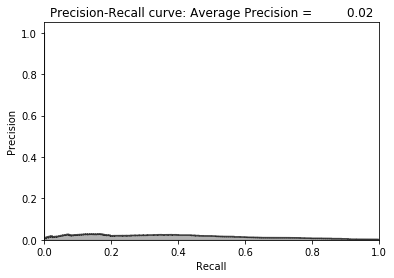

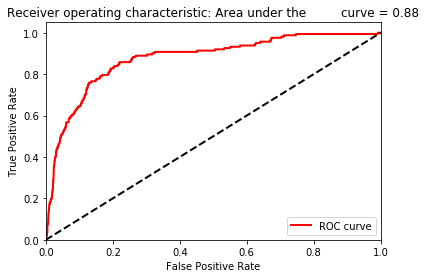

Mean average precision over 10 runs:  0.08093698440100999


[0.009946196203071253,
 0.041946566773514576,
 0.16216824130427698,
 0.22974295425223115,
 0.028652696889240648,
 0.053887359404900144,
 0.02212888556178773,
 0.02916483257925153,
 0.21601110666783635,
 0.01572100437398965]

In [17]:
# Model three
# Three layer undercomplete autoencoder with linear activation
# With 28 and 27 nodes in the two hidden layers, respectively

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [18]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.08093698440100999
Coefficient of variation over 10 runs:  1.014367877185493


[0.009946196203071253,
 0.041946566773514576,
 0.16216824130427698,
 0.22974295425223115,
 0.028652696889240648,
 0.053887359404900144,
 0.02212888556178773,
 0.02916483257925153,
 0.21601110666783635,
 0.01572100437398965]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 18s 96us/step - loss: 0.6921 - acc: 0.5704 - val_loss: 0.6506 - val_acc: 0.6465
Epoch 2/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.6245 - acc: 0.7129 - val_loss: 0.6149 - val_acc: 0.7406
Epoch 3/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.6118 - acc: 0.7509 - val_loss: 0.6019 - val_acc: 0.7825
Epoch 4/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.6064 - acc: 0.7818 - val_loss: 0.6003 - val_acc: 0.7876
Epoch 5/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.5993 - acc: 0.7860 - val_loss: 0.5958 - val_acc: 0.7978
Epoch 6/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.5991 - acc: 0.7880 - val_loss: 0.5989 - val_acc: 0.7999
Epoch 7/10
190820/190820 [==============================] - 16s 82us/step - loss: 0.5958 - acc: 0.7937 - val

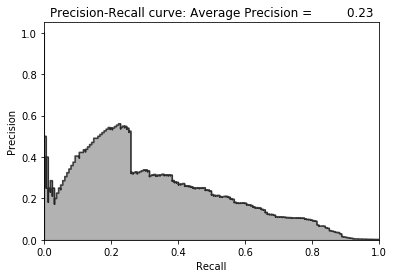

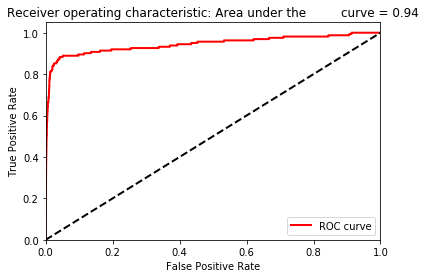

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.6768 - acc: 0.6262 - val_loss: 0.6139 - val_acc: 0.7651
Epoch 2/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.5984 - acc: 0.8022 - val_loss: 0.5878 - val_acc: 0.8375
Epoch 3/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.5918 - acc: 0.8196 - val_loss: 0.5869 - val_acc: 0.8091
Epoch 4/10
190820/190820 [==============================] - 16s 83us/step - loss: 0.5862 - acc: 0.8344 - val_loss: 0.5863 - val_acc: 0.8431
Epoch 5/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.5836 - acc: 0.8478 - val_loss: 0.5813 - val_acc: 0.8583
Epoch 6/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.5824 - acc: 0.8506 - val_loss: 0.5808 - val_acc: 0.8603
Epoch 7/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.5820 - acc: 0.8513 - va

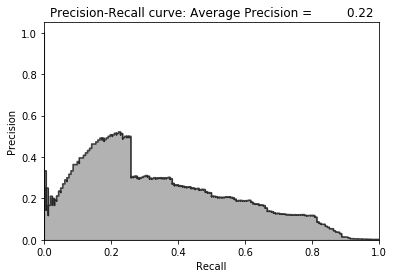

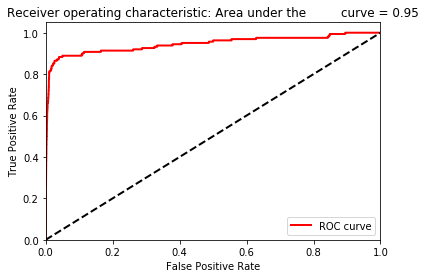

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 100us/step - loss: 0.6619 - acc: 0.6731 - val_loss: 0.6001 - val_acc: 0.8221
Epoch 2/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.5821 - acc: 0.8537 - val_loss: 0.5870 - val_acc: 0.7820
Epoch 3/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5730 - acc: 0.8786 - val_loss: 0.5661 - val_acc: 0.9050
Epoch 4/10
190820/190820 [==============================] - 16s 84us/step - loss: 0.5716 - acc: 0.8824 - val_loss: 0.5646 - val_acc: 0.9112
Epoch 5/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5698 - acc: 0.8834 - val_loss: 0.5636 - val_acc: 0.9091
Epoch 6/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.5694 - acc: 0.8858 - val_loss: 0.5661 - val_acc: 0.8771
Epoch 7/10
190820/190820 [==============================] - 16s 85us/step - loss: 0.5635 - acc: 0.8943 - va

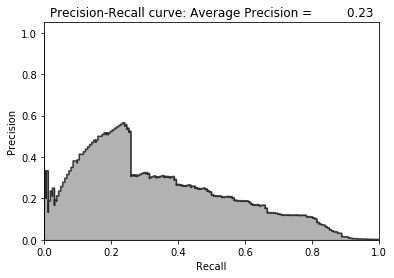

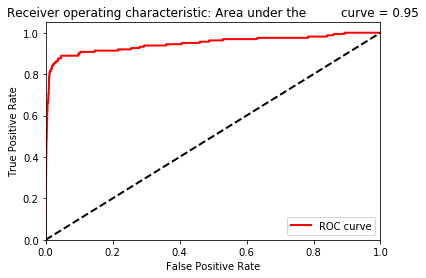

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.6674 - acc: 0.6313 - val_loss: 0.6058 - val_acc: 0.7659
Epoch 2/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.6010 - acc: 0.7792 - val_loss: 0.5888 - val_acc: 0.8156
Epoch 3/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.5884 - acc: 0.8043 - val_loss: 0.5820 - val_acc: 0.8213
Epoch 4/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5887 - acc: 0.8017 - val_loss: 0.5928 - val_acc: 0.8015
Epoch 5/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.5923 - acc: 0.7914 - val_loss: 0.5765 - val_acc: 0.8389
Epoch 6/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.5799 - acc: 0.8301 - val_loss: 0.5800 - val_acc: 0.8222
Epoch 7/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5782 - acc: 0.8335 - val

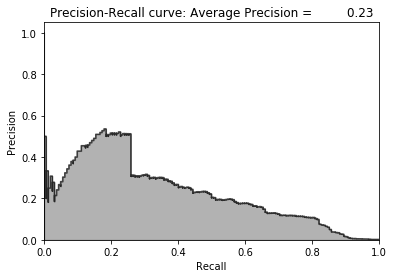

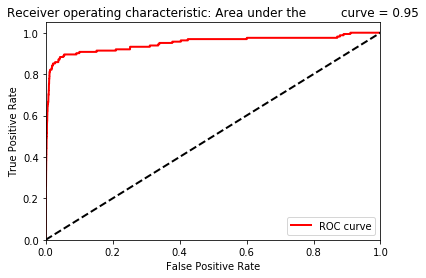

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 99us/step - loss: 0.6467 - acc: 0.6510 - val_loss: 0.5784 - val_acc: 0.7870
Epoch 2/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5680 - acc: 0.8065 - val_loss: 0.5701 - val_acc: 0.8091
Epoch 3/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5532 - acc: 0.8486 - val_loss: 0.5451 - val_acc: 0.8718
Epoch 4/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.5415 - acc: 0.8766 - val_loss: 0.5369 - val_acc: 0.8784
Epoch 5/10
190820/190820 [==============================] - 17s 87us/step - loss: 0.5365 - acc: 0.8909 - val_loss: 0.5318 - val_acc: 0.9018
Epoch 6/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5339 - acc: 0.8937 - val_loss: 0.5358 - val_acc: 0.8511
Epoch 7/10
190820/190820 [==============================] - 16s 86us/step - loss: 0.5312 - acc: 0.8975 - val

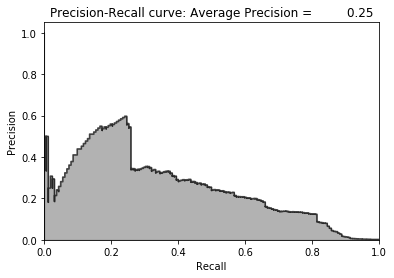

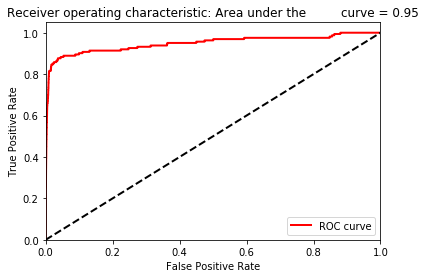

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.6690 - acc: 0.5884 - val_loss: 0.5961 - val_acc: 0.7332
Epoch 2/10
190820/190820 [==============================] - 17s 88us/step - loss: 0.5896 - acc: 0.7445 - val_loss: 0.5829 - val_acc: 0.7625
Epoch 3/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.5820 - acc: 0.7603 - val_loss: 0.5776 - val_acc: 0.7849
Epoch 4/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.5839 - acc: 0.7565 - val_loss: 0.5793 - val_acc: 0.7629
Epoch 5/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.5793 - acc: 0.7693 - val_loss: 0.5753 - val_acc: 0.7708
Epoch 6/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.5773 - acc: 0.7733 - val_loss: 0.5763 - val_acc: 0.7709
Epoch 7/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.5764 - acc: 0.7759 - va

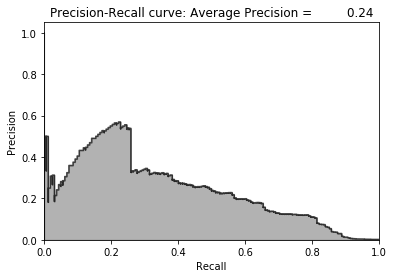

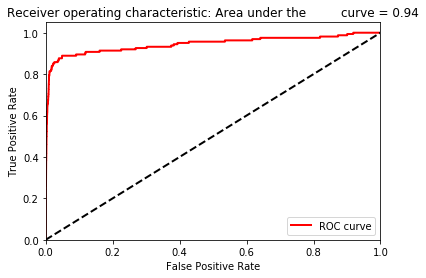

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.6715 - acc: 0.6135 - val_loss: 0.5951 - val_acc: 0.7534
Epoch 2/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.5887 - acc: 0.7599 - val_loss: 0.5824 - val_acc: 0.7579
Epoch 3/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.5766 - acc: 0.7925 - val_loss: 0.5690 - val_acc: 0.8233
Epoch 4/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.5743 - acc: 0.8085 - val_loss: 0.6394 - val_acc: 0.6230
Epoch 5/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.5714 - acc: 0.8113 - val_loss: 0.5651 - val_acc: 0.8297
Epoch 6/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.5710 - acc: 0.8140 - val_loss: 0.5753 - val_acc: 0.8093
Epoch 7/10
190820/190820 [==============================] - 17s 89us/step - loss: 0.5689 - acc: 0.8201 - va

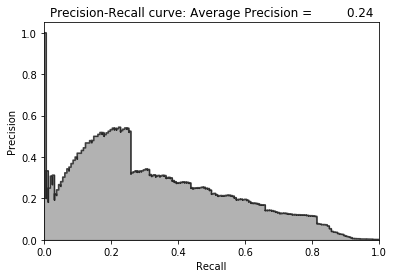

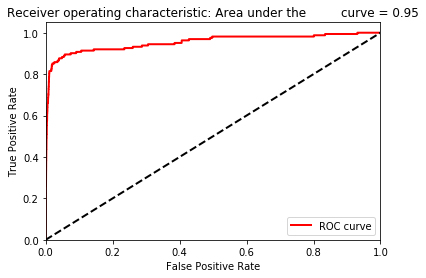

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.6595 - acc: 0.6296 - val_loss: 0.5979 - val_acc: 0.7574
Epoch 2/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.5903 - acc: 0.7671 - val_loss: 0.5766 - val_acc: 0.7955
Epoch 3/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.5667 - acc: 0.8109 - val_loss: 0.5591 - val_acc: 0.8313
Epoch 4/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.5610 - acc: 0.8274 - val_loss: 0.5576 - val_acc: 0.8400
Epoch 5/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.5597 - acc: 0.8291 - val_loss: 0.5644 - val_acc: 0.7889
Epoch 6/10
190820/190820 [==============================] - 17s 90us/step - loss: 0.5586 - acc: 0.8359 - val_loss: 0.5563 - val_acc: 0.8436
Epoch 7/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.5584 - acc: 0.8375 - va

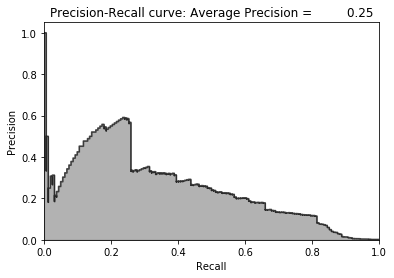

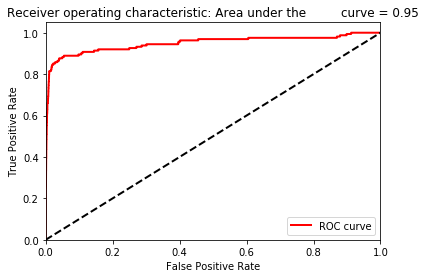

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.6872 - acc: 0.6289 - val_loss: 0.6302 - val_acc: 0.7453
Epoch 2/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.6302 - acc: 0.7496 - val_loss: 0.6303 - val_acc: 0.7514
Epoch 3/10
190820/190820 [==============================] - 19s 97us/step - loss: 0.6233 - acc: 0.7692 - val_loss: 0.6286 - val_acc: 0.7544
Epoch 4/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.6140 - acc: 0.7922 - val_loss: 0.6117 - val_acc: 0.7721
Epoch 5/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.6089 - acc: 0.7980 - val_loss: 0.6243 - val_acc: 0.7709
Epoch 6/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.6080 - acc: 0.8025 - val_loss: 0.6038 - val_acc: 0.8177
Epoch 7/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.6079 - acc: 0.8028 - va

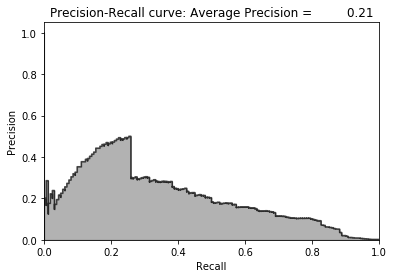

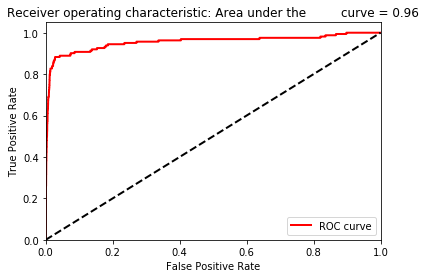

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.6733 - acc: 0.6294 - val_loss: 0.6221 - val_acc: 0.7399
Epoch 2/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.6217 - acc: 0.7452 - val_loss: 0.6320 - val_acc: 0.7459
Epoch 3/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.6280 - acc: 0.7525 - val_loss: 0.6161 - val_acc: 0.7940
Epoch 4/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.6193 - acc: 0.7742 - val_loss: 0.6152 - val_acc: 0.8001
Epoch 5/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.6183 - acc: 0.7814 - val_loss: 0.6149 - val_acc: 0.7983
Epoch 6/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.6164 - acc: 0.7832 - val_loss: 0.6161 - val_acc: 0.7941
Epoch 7/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.6167 - acc: 0.7841 - va

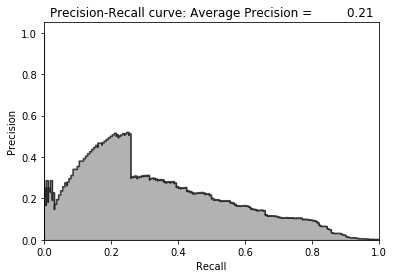

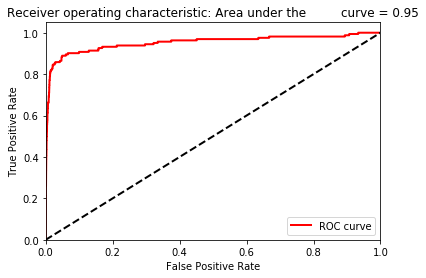

Mean average precision over 10 runs:  0.23297520331227567


[0.23227068584428567,
 0.22395145485213824,
 0.2309647299749825,
 0.22963773119250194,
 0.2541432011854016,
 0.24267968356229241,
 0.2423739038761084,
 0.25309872167682895,
 0.20755083702184576,
 0.21308108393637104]

In [19]:
# Model four
# Four layer undercomplete autoencoder with ReLu activation
# 29 -> 27 -> 22 -> 27 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [20]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.23297520331227567
Coefficient of variation over 10 runs:  0.06329992135005648


[0.23227068584428567,
 0.22395145485213824,
 0.2309647299749825,
 0.22963773119250194,
 0.2541432011854016,
 0.24267968356229241,
 0.2423739038761084,
 0.25309872167682895,
 0.20755083702184576,
 0.21308108393637104]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0532 - acc: 0.9325 - val_loss: 2.1519e-04 - val_acc: 0.9927
Epoch 2/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.0010 - acc: 0.9926 - val_loss: 4.0767e-05 - val_acc: 0.9976
Epoch 3/10
190820/190820 [==============================] - 18s 92us/step - loss: 8.3386e-04 - acc: 0.9923 - val_loss: 1.2864e-04 - val_acc: 0.9963
Epoch 4/10
190820/190820 [==============================] - 18s 96us/step - loss: 7.2221e-04 - acc: 0.9934 - val_loss: 7.4001e-05 - val_acc: 0.9978
Epoch 5/10
190820/190820 [==============================] - 17s 89us/step - loss: 7.8242e-04 - acc: 0.9947 - val_loss: 2.2452e-06 - val_acc: 0.9996
Epoch 6/10
190820/190820 [==============================] - 17s 91us/step - loss: 6.1673e-04 - acc: 0.9941 - val_loss: 1.6115e-05 - val_acc: 0.9985
Epoch 7/10
190820/190820 [==============================] - 17s 90u

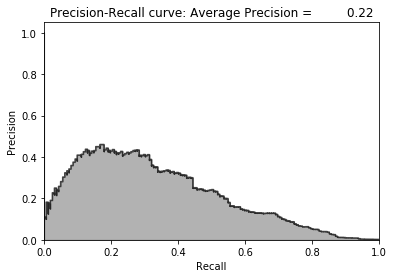

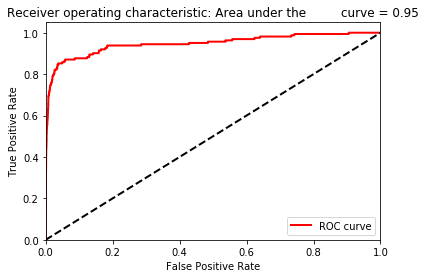

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0491 - acc: 0.9324 - val_loss: 4.7939e-05 - val_acc: 0.9983
Epoch 2/10
190820/190820 [==============================] - 17s 91us/step - loss: 9.7280e-04 - acc: 0.9924 - val_loss: 8.1548e-05 - val_acc: 0.9954
Epoch 3/10
190820/190820 [==============================] - 17s 92us/step - loss: 0.0030 - acc: 0.9913 - val_loss: 7.7407e-08 - val_acc: 0.9999
Epoch 4/10
190820/190820 [==============================] - 18s 92us/step - loss: 6.7684e-04 - acc: 0.9936 - val_loss: 1.3970e-04 - val_acc: 0.9979
Epoch 5/10
190820/190820 [==============================] - 18s 92us/step - loss: 6.1458e-04 - acc: 0.9926 - val_loss: 1.1091e-05 - val_acc: 0.9987
Epoch 6/10
190820/190820 [==============================] - 18s 93us/step - loss: 6.9598e-04 - acc: 0.9936 - val_loss: 1.1168e-05 - val_acc: 0.9999
Epoch 7/10
190820/190820 [==============================] - 18s 95u

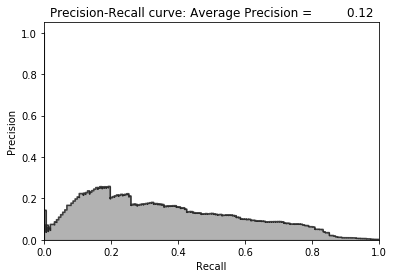

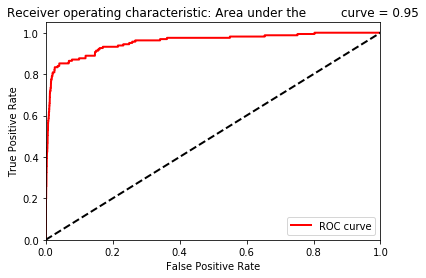

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0481 - acc: 0.9395 - val_loss: 0.0010 - val_acc: 0.9837
Epoch 2/10
190820/190820 [==============================] - 17s 91us/step - loss: 9.2447e-04 - acc: 0.9928 - val_loss: 1.8960e-06 - val_acc: 0.9993
Epoch 3/10
190820/190820 [==============================] - 17s 91us/step - loss: 9.6690e-04 - acc: 0.9928 - val_loss: 1.0847e-05 - val_acc: 0.9985
Epoch 4/10
190820/190820 [==============================] - 18s 92us/step - loss: 8.1937e-04 - acc: 0.9932 - val_loss: 1.5639e-05 - val_acc: 0.9984
Epoch 5/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.0015 - acc: 0.9922 - val_loss: 1.1932e-05 - val_acc: 0.9990
Epoch 6/10
190820/190820 [==============================] - 17s 91us/step - loss: 7.3188e-04 - acc: 0.9958 - val_loss: 2.6597e-06 - val_acc: 0.9991
Epoch 7/10
190820/190820 [==============================] - 18s 92us/st

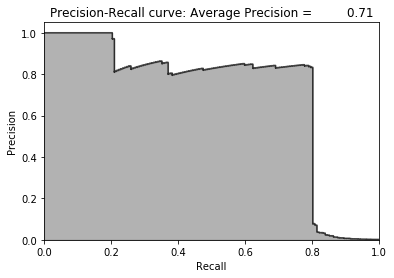

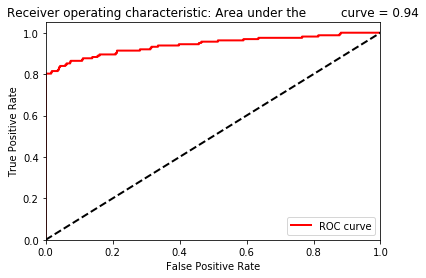

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0530 - acc: 0.9360 - val_loss: 1.3771e-05 - val_acc: 0.9987
Epoch 2/10
190820/190820 [==============================] - 17s 91us/step - loss: 6.6626e-04 - acc: 0.9938 - val_loss: 1.7124e-06 - val_acc: 0.9993
Epoch 3/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.0010 - acc: 0.9927 - val_loss: 0.0039 - val_acc: 0.9615
Epoch 4/10
190820/190820 [==============================] - 18s 92us/step - loss: 7.8648e-04 - acc: 0.9928 - val_loss: 4.2023e-05 - val_acc: 0.9962
Epoch 5/10
190820/190820 [==============================] - 18s 95us/step - loss: 5.8645e-04 - acc: 0.9947 - val_loss: 8.3195e-05 - val_acc: 0.9957
Epoch 6/10
190820/190820 [==============================] - 18s 92us/step - loss: 6.5160e-04 - acc: 0.9933 - val_loss: 5.4812e-05 - val_acc: 0.9972
Epoch 7/10
190820/190820 [==============================] - 18s 92us/st

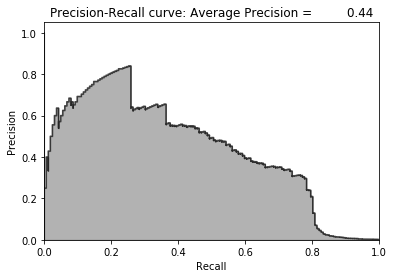

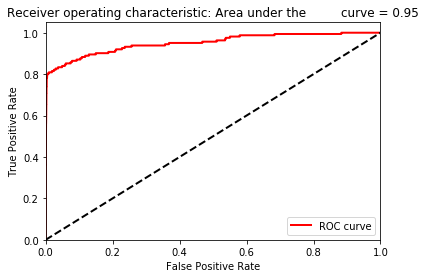

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0547 - acc: 0.9297 - val_loss: 1.1638e-04 - val_acc: 0.9965
Epoch 2/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.0011 - acc: 0.9912 - val_loss: 9.1384e-05 - val_acc: 0.9956
Epoch 3/10
190820/190820 [==============================] - 17s 91us/step - loss: 0.0013 - acc: 0.9921 - val_loss: 1.5696e-04 - val_acc: 0.9941
Epoch 4/10
190820/190820 [==============================] - 17s 91us/step - loss: 6.2008e-04 - acc: 0.9943 - val_loss: 7.4163e-05 - val_acc: 0.9965
Epoch 5/10
190820/190820 [==============================] - 17s 92us/step - loss: 7.0409e-04 - acc: 0.9930 - val_loss: 8.1301e-05 - val_acc: 0.9959
Epoch 6/10
190820/190820 [==============================] - 17s 92us/step - loss: 6.7939e-04 - acc: 0.9935 - val_loss: 1.7256e-07 - val_acc: 0.9998
Epoch 7/10
190820/190820 [==============================] - 17s 91us/st

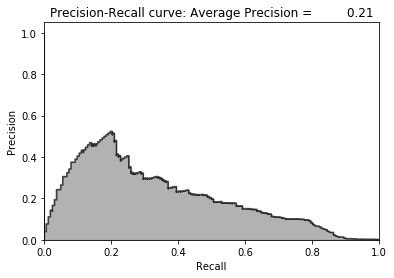

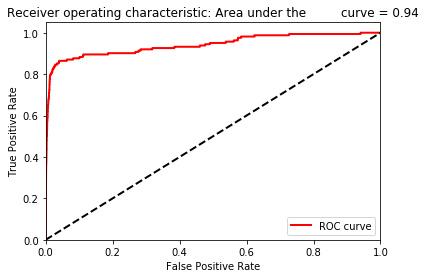

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 111us/step - loss: 0.0518 - acc: 0.9384 - val_loss: 7.4799e-05 - val_acc: 0.9961
Epoch 2/10
190820/190820 [==============================] - 18s 95us/step - loss: 0.0012 - acc: 0.9921 - val_loss: 7.6008e-06 - val_acc: 0.9987
Epoch 3/10
190820/190820 [==============================] - 18s 93us/step - loss: 6.0050e-04 - acc: 0.9942 - val_loss: 3.2248e-05 - val_acc: 0.9996
Epoch 4/10
190820/190820 [==============================] - 18s 95us/step - loss: 7.1529e-04 - acc: 0.9932 - val_loss: 3.9543e-08 - val_acc: 0.9999
Epoch 5/10
190820/190820 [==============================] - 18s 93us/step - loss: 0.0010 - acc: 0.9930 - val_loss: 2.6135e-06 - val_acc: 0.9995
Epoch 6/10
190820/190820 [==============================] - 18s 92us/step - loss: 6.4620e-04 - acc: 0.9941 - val_loss: 0.0022 - val_acc: 0.9926
Epoch 7/10
190820/190820 [==============================] - 18s 92us/step -

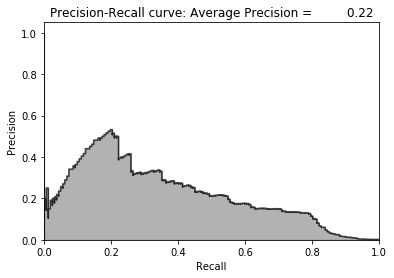

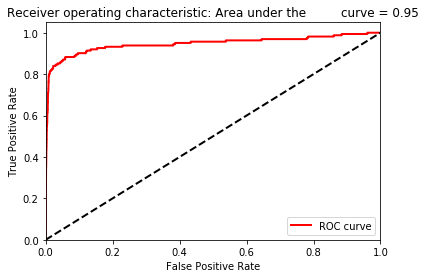

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0455 - acc: 0.9412 - val_loss: 9.1843e-04 - val_acc: 0.9936
Epoch 2/10
190820/190820 [==============================] - 18s 94us/step - loss: 8.1128e-04 - acc: 0.9921 - val_loss: 8.8618e-05 - val_acc: 0.9957
Epoch 3/10
190820/190820 [==============================] - 18s 93us/step - loss: 7.9215e-04 - acc: 0.9938 - val_loss: 6.7732e-06 - val_acc: 0.9986
Epoch 4/10
190820/190820 [==============================] - 18s 92us/step - loss: 7.3214e-04 - acc: 0.9931 - val_loss: 0.0031 - val_acc: 0.9790
Epoch 5/10
190820/190820 [==============================] - 18s 92us/step - loss: 0.0013 - acc: 0.9929 - val_loss: 9.5442e-06 - val_acc: 0.9980
Epoch 6/10
190820/190820 [==============================] - 18s 92us/step - loss: 7.4606e-04 - acc: 0.9941 - val_loss: 1.9754e-05 - val_acc: 0.9982
Epoch 7/10
190820/190820 [==============================] - 17s 92us/st

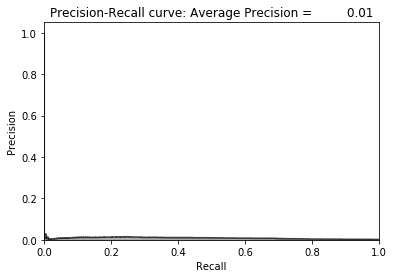

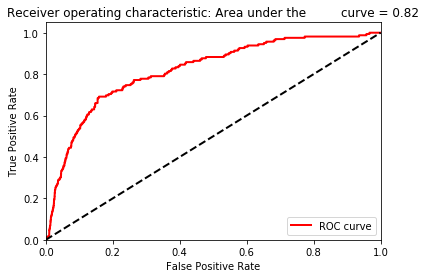

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0943 - acc: 0.8967 - val_loss: 1.7979e-04 - val_acc: 0.9947
Epoch 2/10
190820/190820 [==============================] - 18s 94us/step - loss: 8.7803e-04 - acc: 0.9928 - val_loss: 0.0036 - val_acc: 0.9713
Epoch 3/10
190820/190820 [==============================] - 18s 94us/step - loss: 8.4368e-04 - acc: 0.9933 - val_loss: 6.9288e-08 - val_acc: 0.9999
Epoch 4/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.0030 - acc: 0.9888 - val_loss: 4.7827e-04 - val_acc: 0.9889
Epoch 5/10
190820/190820 [==============================] - 18s 94us/step - loss: 5.8737e-04 - acc: 0.9934 - val_loss: 0.0075 - val_acc: 0.9649
Epoch 6/10
190820/190820 [==============================] - 18s 93us/step - loss: 8.0918e-04 - acc: 0.9944 - val_loss: 3.3085e-04 - val_acc: 0.9978
Epoch 7/10
190820/190820 [==============================] - 18s 94us/step -

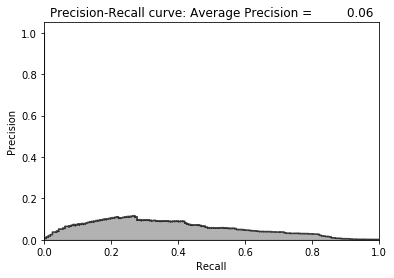

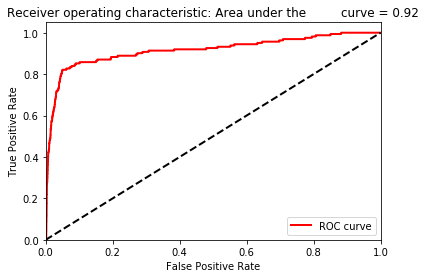

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0586 - acc: 0.9302 - val_loss: 1.0147e-05 - val_acc: 0.9989
Epoch 2/10
190820/190820 [==============================] - 18s 95us/step - loss: 0.0010 - acc: 0.9932 - val_loss: 0.0030 - val_acc: 0.9722
Epoch 3/10
190820/190820 [==============================] - 18s 94us/step - loss: 0.0011 - acc: 0.9919 - val_loss: 1.2785e-04 - val_acc: 0.9936
Epoch 4/10
190820/190820 [==============================] - 18s 95us/step - loss: 7.8021e-04 - acc: 0.9937 - val_loss: 4.0478e-07 - val_acc: 0.9997
Epoch 5/10
190820/190820 [==============================] - 19s 100us/step - loss: 6.6580e-04 - acc: 0.9943 - val_loss: 5.3786e-04 - val_acc: 0.9905
Epoch 6/10
190820/190820 [==============================] - 19s 97us/step - loss: 9.3645e-04 - acc: 0.9919 - val_loss: 1.3787e-05 - val_acc: 0.9986
Epoch 7/10
190820/190820 [==============================] - 19s 98us/step 

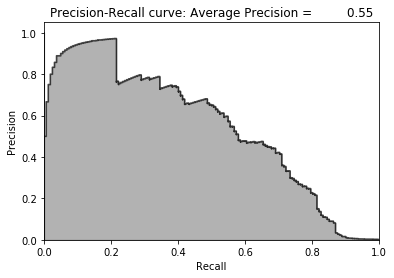

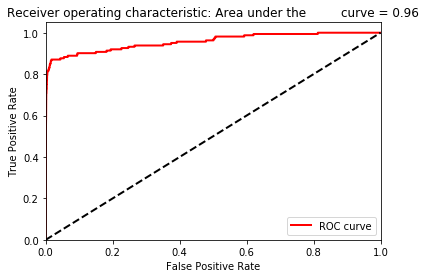

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0491 - acc: 0.9391 - val_loss: 9.1063e-06 - val_acc: 0.9989
Epoch 2/10
190820/190820 [==============================] - 18s 97us/step - loss: 0.0017 - acc: 0.9923 - val_loss: 0.0068 - val_acc: 0.9647
Epoch 3/10
190820/190820 [==============================] - 18s 97us/step - loss: 9.4545e-04 - acc: 0.9934 - val_loss: 1.2785e-05 - val_acc: 0.9980
Epoch 4/10
190820/190820 [==============================] - 18s 97us/step - loss: 6.3780e-04 - acc: 0.9942 - val_loss: 1.9528e-05 - val_acc: 0.9987
Epoch 5/10
190820/190820 [==============================] - 18s 97us/step - loss: 0.0011 - acc: 0.9932 - val_loss: 9.5701e-07 - val_acc: 0.9997
Epoch 6/10
190820/190820 [==============================] - 18s 96us/step - loss: 6.2906e-04 - acc: 0.9940 - val_loss: 8.2017e-06 - val_acc: 0.9991
Epoch 7/10
190820/190820 [==============================] - 18s 97us/step -

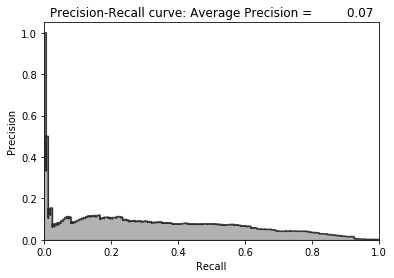

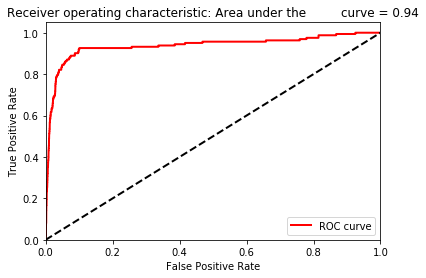

Mean average precision over 10 runs:  0.26003811440587316


[0.21895218665478897,
 0.11933506759408899,
 0.7072883391547395,
 0.4398415580476769,
 0.2054267499797046,
 0.22163200931226418,
 0.008594434335308992,
 0.055849565642660345,
 0.5485024705818721,
 0.07495876275562707]

In [21]:
# Model five
# Two layer overcomplete autoencoder with linear activation
# 29 -> 40 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [22]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.26003811440587316
Coefficient of variation over 10 runs:  0.8431300085529204


[0.21895218665478897,
 0.11933506759408899,
 0.7072883391547395,
 0.4398415580476769,
 0.2054267499797046,
 0.22163200931226418,
 0.008594434335308992,
 0.055849565642660345,
 0.5485024705818721,
 0.07495876275562707]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.1367 - acc: 0.7381 - val_loss: 0.0144 - val_acc: 0.9659
Epoch 2/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0761 - acc: 0.7854 - val_loss: 0.0082 - val_acc: 0.9739
Epoch 3/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0769 - acc: 0.7842 - val_loss: 0.0071 - val_acc: 0.9761
Epoch 4/10
190820/190820 [==============================] - 19s 100us/step - loss: 0.0769 - acc: 0.7854 - val_loss: 0.0078 - val_acc: 0.9676
Epoch 5/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0760 - acc: 0.7841 - val_loss: 0.0094 - val_acc: 0.9710
Epoch 6/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.0757 - acc: 0.7869 - val_loss: 0.0088 - val

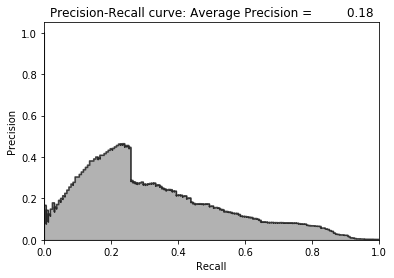

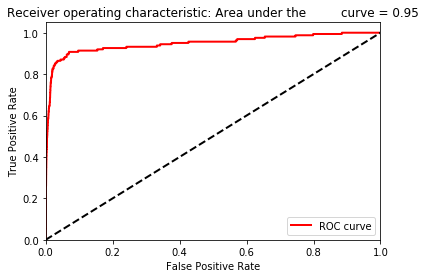

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.1350 - acc: 0.7457 - val_loss: 0.0086 - val_acc: 0.9672
Epoch 2/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.0773 - acc: 0.7859 - val_loss: 0.0072 - val_acc: 0.9770
Epoch 3/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0774 - acc: 0.7867 - val_loss: 0.0140 - val_acc: 0.9645
Epoch 4/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0768 - acc: 0.7865 - val_loss: 0.0083 - val_acc: 0.9718
Epoch 5/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0768 - acc: 0.7887 - val_loss: 0.0072 - val_acc: 0.9758
Epoch 6/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0777 - acc: 0.7884 - val_loss: 0.0069 - val_acc: 0.9785
Epoch 7/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0761 - acc: 0.788

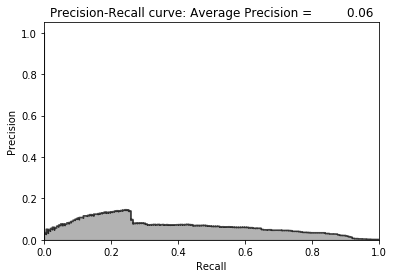

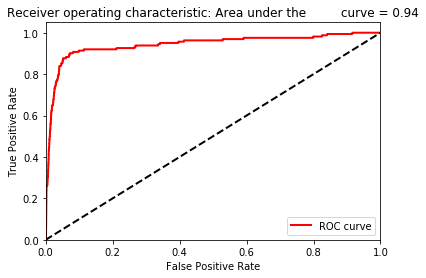

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.1493 - acc: 0.7318 - val_loss: 0.0177 - val_acc: 0.9548
Epoch 2/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.0752 - acc: 0.7856 - val_loss: 0.0089 - val_acc: 0.9735
Epoch 3/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0768 - acc: 0.7872 - val_loss: 0.0074 - val_acc: 0.9764
Epoch 4/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0761 - acc: 0.7870 - val_loss: 0.0074 - val_acc: 0.9767
Epoch 5/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0751 - acc: 0.7884 - val_loss: 0.0082 - val_acc: 0.9712
Epoch 6/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0778 - acc: 0.7870 - val_loss: 0.0067 - val_acc: 0.9758
Epoch 7/10
190820/190820 [==============================] - 20s 102us/step - loss: 0.0751 - acc: 0.788

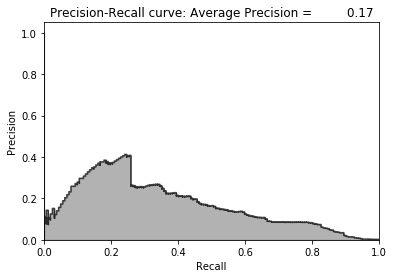

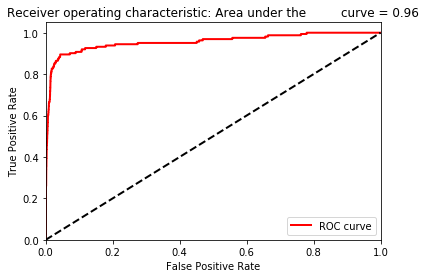

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.1397 - acc: 0.7347 - val_loss: 0.0077 - val_acc: 0.9742
Epoch 2/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0770 - acc: 0.7850 - val_loss: 0.0082 - val_acc: 0.9736
Epoch 3/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0780 - acc: 0.7883 - val_loss: 0.0073 - val_acc: 0.9748
Epoch 4/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0765 - acc: 0.7888 - val_loss: 0.0086 - val_acc: 0.9747
Epoch 5/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.0774 - acc: 0.7878 - val_loss: 0.0075 - val_acc: 0.9772
Epoch 6/10
190820/190820 [==============================] - 19s 102us/step - loss: 0.0776 - acc: 0.7862 - val_loss: 0.0072 - val_acc: 0.9751
Epoch 7/10
190820/190820 [==============================] - 19s 101us/step - loss: 0.0758 - acc: 0.786

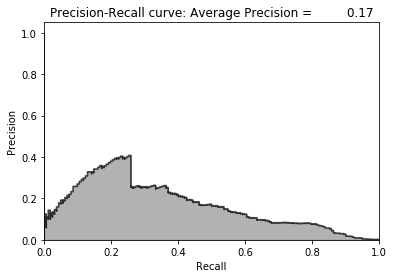

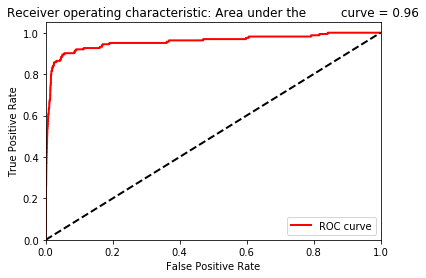

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 123us/step - loss: 0.1411 - acc: 0.7375 - val_loss: 0.0109 - val_acc: 0.9623
Epoch 2/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0770 - acc: 0.7859 - val_loss: 0.0077 - val_acc: 0.9748
Epoch 3/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0759 - acc: 0.7875 - val_loss: 0.0088 - val_acc: 0.9706
Epoch 4/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0749 - acc: 0.7888 - val_loss: 0.0082 - val_acc: 0.9736
Epoch 5/10
190820/190820 [==============================] - 20s 102us/step - loss: 0.0752 - acc: 0.7884 - val_loss: 0.0073 - val_acc: 0.9749
Epoch 6/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0751 - acc: 0.7865 - val_loss: 0.0077 - val_acc: 0.9711
Epoch 7/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0764 - acc: 0.788

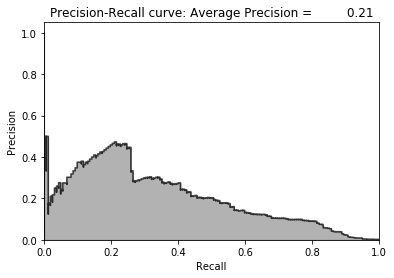

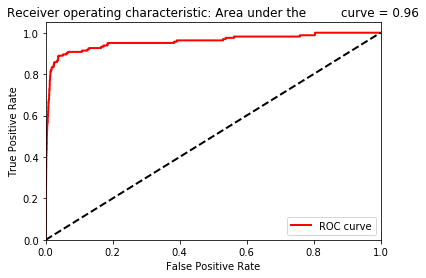

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 23s 123us/step - loss: 0.1517 - acc: 0.7311 - val_loss: 0.0097 - val_acc: 0.9721
Epoch 2/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0759 - acc: 0.7837 - val_loss: 0.0080 - val_acc: 0.9753
Epoch 3/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0765 - acc: 0.7846 - val_loss: 0.0090 - val_acc: 0.9682
Epoch 4/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0775 - acc: 0.7855 - val_loss: 0.0088 - val_acc: 0.9712
Epoch 5/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0764 - acc: 0.7860 - val_loss: 0.0131 - val_acc: 0.9645
Epoch 6/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0765 - acc: 0.7858 - val_loss: 0.0090 - val_acc: 0.9678
Epoch 7/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0762 - acc: 0.784

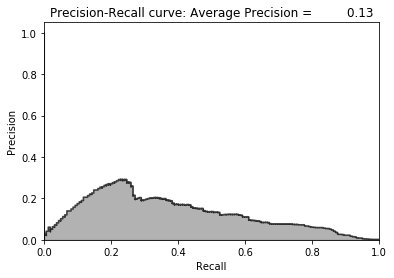

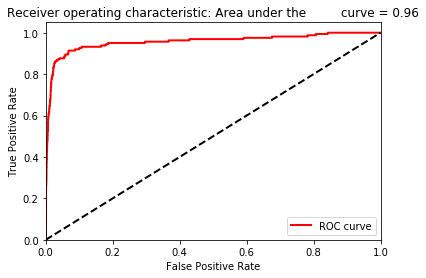

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 125us/step - loss: 0.1315 - acc: 0.7426 - val_loss: 0.0082 - val_acc: 0.9726
Epoch 2/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0765 - acc: 0.7874 - val_loss: 0.0081 - val_acc: 0.9752
Epoch 3/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0786 - acc: 0.7854 - val_loss: 0.0074 - val_acc: 0.9756
Epoch 4/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0762 - acc: 0.7855 - val_loss: 0.0079 - val_acc: 0.9718
Epoch 5/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0757 - acc: 0.7848 - val_loss: 0.0076 - val_acc: 0.9741
Epoch 6/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0758 - acc: 0.7870 - val_loss: 0.0065 - val_acc: 0.9753
Epoch 7/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0770 - acc: 0.786

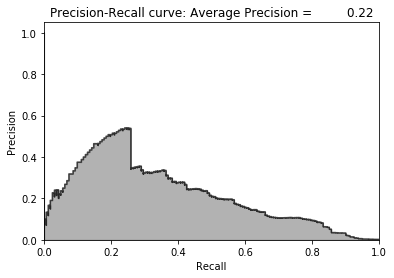

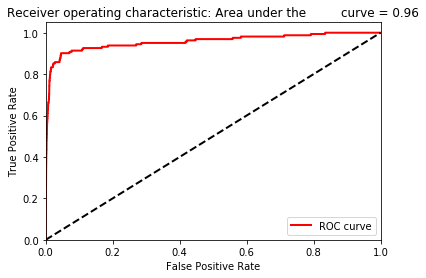

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.1511 - acc: 0.7318 - val_loss: 0.0074 - val_acc: 0.9742
Epoch 2/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0770 - acc: 0.7832 - val_loss: 0.0076 - val_acc: 0.9764
Epoch 3/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0752 - acc: 0.7871 - val_loss: 0.0079 - val_acc: 0.9723
Epoch 4/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0758 - acc: 0.7858 - val_loss: 0.0085 - val_acc: 0.9757
Epoch 5/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0771 - acc: 0.7850 - val_loss: 0.0077 - val_acc: 0.9727
Epoch 6/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0766 - acc: 0.7864 - val_loss: 0.0109 - val_acc: 0.9675
Epoch 7/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0765 - acc: 0.785

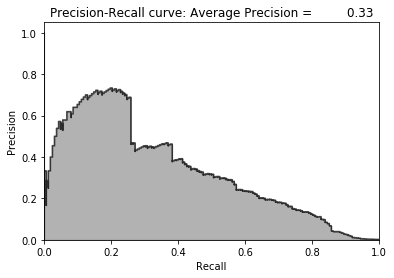

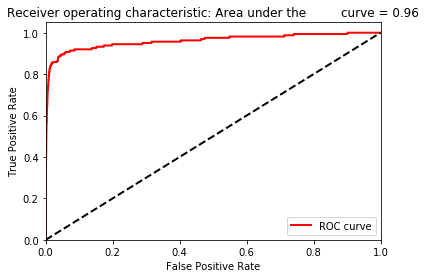

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.1359 - acc: 0.7445 - val_loss: 0.0327 - val_acc: 0.9201
Epoch 2/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0772 - acc: 0.7859 - val_loss: 0.0075 - val_acc: 0.9749
Epoch 3/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0755 - acc: 0.7879 - val_loss: 0.0074 - val_acc: 0.9766
Epoch 4/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0776 - acc: 0.7870 - val_loss: 0.0068 - val_acc: 0.9794
Epoch 5/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0767 - acc: 0.7862 - val_loss: 0.0070 - val_acc: 0.9778
Epoch 6/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0776 - acc: 0.7859 - val_loss: 0.0078 - val_acc: 0.9749
Epoch 7/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0760 - acc: 0.786

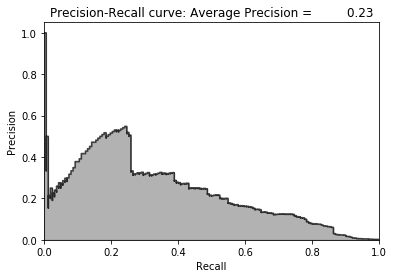

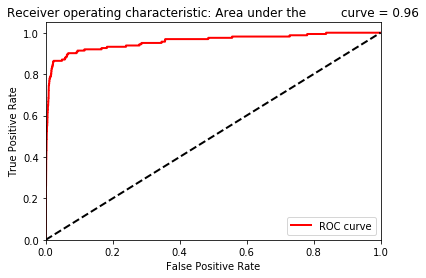

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.1523 - acc: 0.7303 - val_loss: 0.0079 - val_acc: 0.9775
Epoch 2/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0758 - acc: 0.7855 - val_loss: 0.0071 - val_acc: 0.9776
Epoch 3/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0768 - acc: 0.7831 - val_loss: 0.0067 - val_acc: 0.9806
Epoch 4/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0759 - acc: 0.7848 - val_loss: 0.0090 - val_acc: 0.9691
Epoch 5/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0759 - acc: 0.7856 - val_loss: 0.0070 - val_acc: 0.9773
Epoch 6/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0757 - acc: 0.7850 - val_loss: 0.0091 - val_acc: 0.9725
Epoch 7/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0756 - acc: 0.783

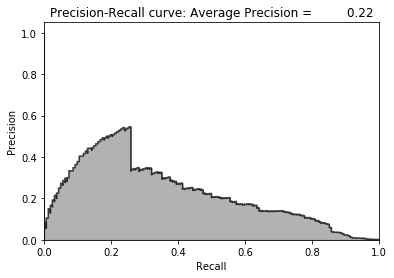

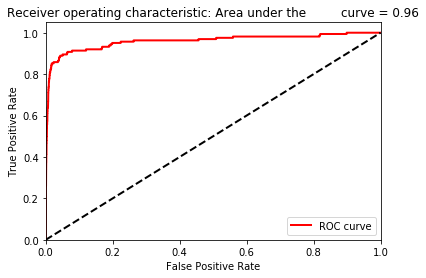

Mean average precision over 10 runs:  0.1923814106040214


[0.17700406774357097,
 0.06470283663486541,
 0.16968596752383283,
 0.16727237858715194,
 0.20583388173790082,
 0.12779339405268883,
 0.2201100368988401,
 0.33410924470894476,
 0.23239317916358407,
 0.2249091189888341]

In [23]:
# Model six
# Two layer overcomplete autoencoder with linear activation and dropout
# 29 -> 40 -> 29
# Dropout percentage: 10%

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [24]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.1923814106040214
Coefficient of variation over 10 runs:  0.3508214403223488


[0.17700406774357097,
 0.06470283663486541,
 0.16968596752383283,
 0.16727237858715194,
 0.20583388173790082,
 0.12779339405268883,
 0.2201100368988401,
 0.33410924470894476,
 0.23239317916358407,
 0.2249091189888341]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 125us/step - loss: 0.0961 - acc: 0.9396 - val_loss: 0.0327 - val_acc: 0.9937
Epoch 2/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0286 - acc: 0.9820 - val_loss: 0.0292 - val_acc: 0.9558
Epoch 3/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0225 - acc: 0.9846 - val_loss: 0.0171 - val_acc: 0.9922
Epoch 4/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0202 - acc: 0.9792 - val_loss: 0.0149 - val_acc: 0.9904
Epoch 5/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0188 - acc: 0.9797 - val_loss: 0.0134 - val_acc: 0.9947
Epoch 6/10
190820/190820 [==============================] - 20s 103us/step - loss: 0.0168 - acc: 0.9816 - val_loss: 0.0131 - val_acc: 0.9833
Epoch 7/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0189 - acc: 0.977

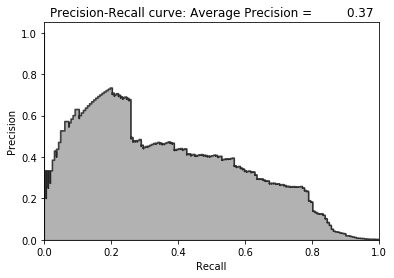

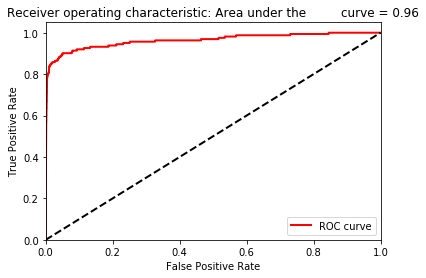

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.1109 - acc: 0.9257 - val_loss: 0.0523 - val_acc: 0.9565
Epoch 2/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0289 - acc: 0.9832 - val_loss: 0.0213 - val_acc: 0.9944
Epoch 3/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0227 - acc: 0.9798 - val_loss: 0.0171 - val_acc: 0.9945
Epoch 4/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0201 - acc: 0.9823 - val_loss: 0.0157 - val_acc: 0.9907
Epoch 5/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0203 - acc: 0.9786 - val_loss: 0.0140 - val_acc: 0.9938
Epoch 6/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0173 - acc: 0.9809 - val_loss: 0.0129 - val_acc: 0.9819
Epoch 7/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0168 - acc: 0.978

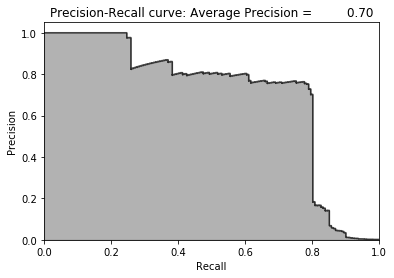

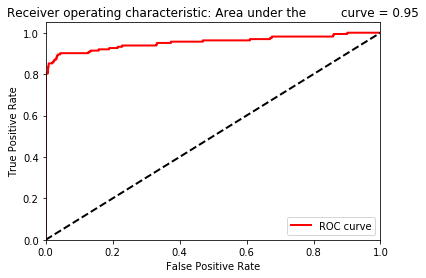

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1100 - acc: 0.9296 - val_loss: 0.0368 - val_acc: 0.9863
Epoch 2/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0284 - acc: 0.9829 - val_loss: 0.0385 - val_acc: 0.9447
Epoch 3/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.0219 - acc: 0.9813 - val_loss: 0.0230 - val_acc: 0.9683
Epoch 4/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0185 - acc: 0.9808 - val_loss: 0.0144 - val_acc: 0.9911
Epoch 5/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0190 - acc: 0.9788 - val_loss: 0.0267 - val_acc: 0.9565
Epoch 6/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0177 - acc: 0.9773 - val_loss: 0.0167 - val_acc: 0.9678
Epoch 7/10
190820/190820 [==============================] - 20s 104us/step - loss: 0.0177 - acc: 0.977

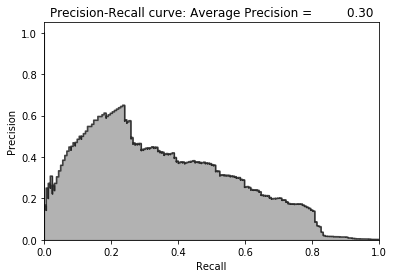

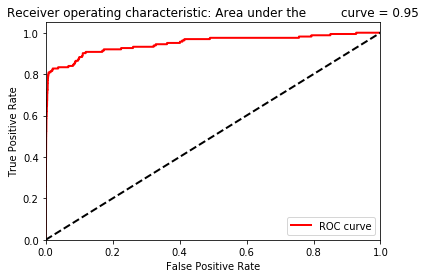

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.1161 - acc: 0.9261 - val_loss: 0.0356 - val_acc: 0.9929
Epoch 2/10
190820/190820 [==============================] - 20s 106us/step - loss: 0.0296 - acc: 0.9841 - val_loss: 0.0284 - val_acc: 0.9622
Epoch 3/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0224 - acc: 0.9825 - val_loss: 0.0180 - val_acc: 0.9869
Epoch 4/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0196 - acc: 0.9803 - val_loss: 0.0154 - val_acc: 0.9931
Epoch 5/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0191 - acc: 0.9793 - val_loss: 0.0135 - val_acc: 0.9964
Epoch 6/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0180 - acc: 0.9798 - val_loss: 0.0201 - val_acc: 0.9417
Epoch 7/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0169 - acc: 0.981

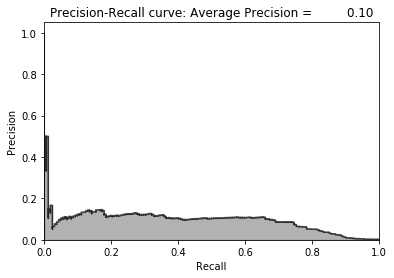

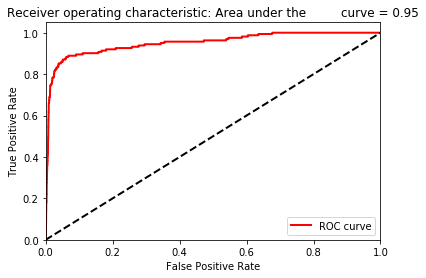

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.1158 - acc: 0.9238 - val_loss: 0.0351 - val_acc: 0.9923
Epoch 2/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0288 - acc: 0.9843 - val_loss: 0.0357 - val_acc: 0.9589
Epoch 3/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0232 - acc: 0.9819 - val_loss: 0.0171 - val_acc: 0.9951
Epoch 4/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0210 - acc: 0.9832 - val_loss: 0.0155 - val_acc: 0.9928
Epoch 5/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0183 - acc: 0.9819 - val_loss: 0.0154 - val_acc: 0.9638
Epoch 6/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0175 - acc: 0.9791 - val_loss: 0.0124 - val_acc: 0.9946
Epoch 7/10
190820/190820 [==============================] - 20s 105us/step - loss: 0.0178 - acc: 0.978

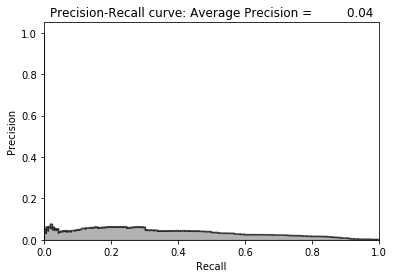

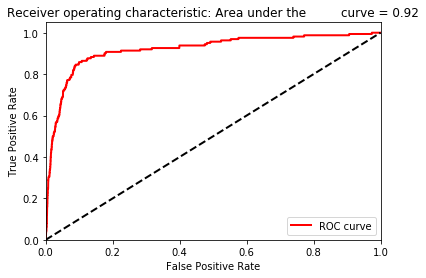

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.1124 - acc: 0.9245 - val_loss: 0.0341 - val_acc: 0.9923
Epoch 2/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0288 - acc: 0.9839 - val_loss: 0.0221 - val_acc: 0.9864
Epoch 3/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0222 - acc: 0.9813 - val_loss: 0.0171 - val_acc: 0.9856
Epoch 4/10
190820/190820 [==============================] - 21s 109us/step - loss: 0.0196 - acc: 0.9811 - val_loss: 0.0155 - val_acc: 0.9771
Epoch 5/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0193 - acc: 0.9804 - val_loss: 0.0135 - val_acc: 0.9927
Epoch 6/10
190820/190820 [==============================] - 20s 107us/step - loss: 0.0177 - acc: 0.9786 - val_loss: 0.0131 - val_acc: 0.9879
Epoch 7/10
190820/190820 [==============================] - 21s 108us/step - loss: 0.0158 - acc: 0.979

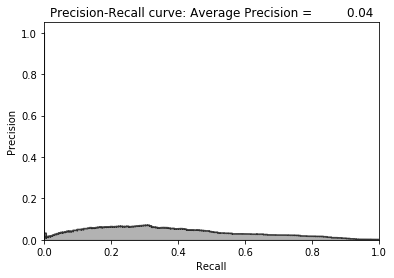

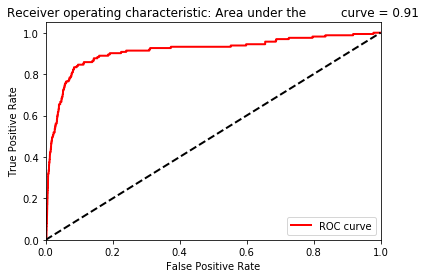

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.1095 - acc: 0.9305 - val_loss: 0.0340 - val_acc: 0.9891
Epoch 2/10
190820/190820 [==============================] - 21s 110us/step - loss: 0.0287 - acc: 0.9813 - val_loss: 0.0211 - val_acc: 0.9932
Epoch 3/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0219 - acc: 0.9832 - val_loss: 0.0170 - val_acc: 0.9951
Epoch 4/10
190820/190820 [==============================] - 22s 118us/step - loss: 0.0192 - acc: 0.9811 - val_loss: 0.0156 - val_acc: 0.9887
Epoch 5/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0189 - acc: 0.9814 - val_loss: 0.0161 - val_acc: 0.9841
Epoch 6/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0173 - acc: 0.9789 - val_loss: 0.0346 - val_acc: 0.9159
Epoch 7/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0175 - acc: 0.979

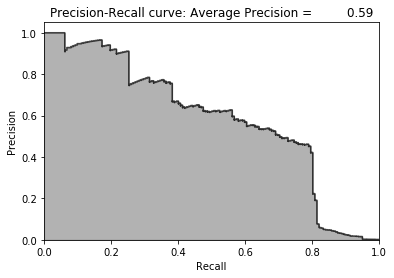

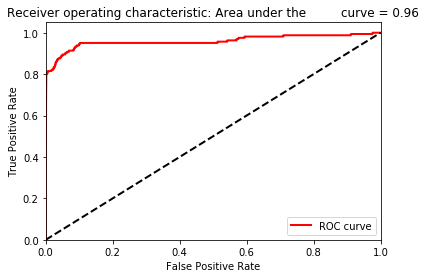

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1330 - acc: 0.9151 - val_loss: 0.0388 - val_acc: 0.9910
Epoch 2/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0307 - acc: 0.9839 - val_loss: 0.0275 - val_acc: 0.9802
Epoch 3/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0241 - acc: 0.9803 - val_loss: 0.0211 - val_acc: 0.9830
Epoch 4/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0203 - acc: 0.9826 - val_loss: 0.0158 - val_acc: 0.9859
Epoch 5/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0197 - acc: 0.9805 - val_loss: 0.0147 - val_acc: 0.9804
Epoch 6/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0189 - acc: 0.9777 - val_loss: 0.0131 - val_acc: 0.9920
Epoch 7/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0182 - acc: 0.981

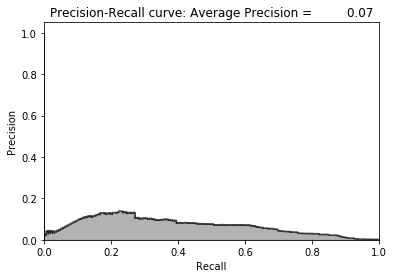

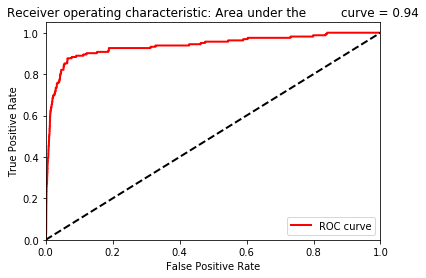

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.1005 - acc: 0.9345 - val_loss: 0.0337 - val_acc: 0.9918
Epoch 2/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0280 - acc: 0.9837 - val_loss: 0.0209 - val_acc: 0.9936
Epoch 3/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0208 - acc: 0.9821 - val_loss: 0.0281 - val_acc: 0.9730
Epoch 4/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.0193 - acc: 0.9794 - val_loss: 0.0185 - val_acc: 0.9638
Epoch 5/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0171 - acc: 0.9813 - val_loss: 0.0285 - val_acc: 0.9334
Epoch 6/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0182 - acc: 0.9741 - val_loss: 0.0120 - val_acc: 0.9955
Epoch 7/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0163 - acc: 0.982

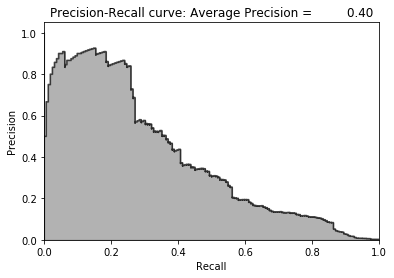

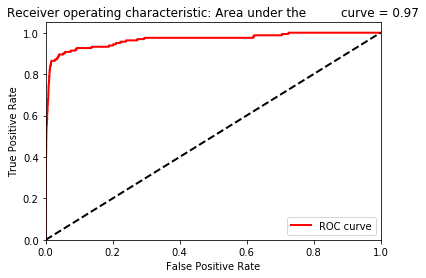

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.1144 - acc: 0.9250 - val_loss: 0.0822 - val_acc: 0.9428
Epoch 2/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0306 - acc: 0.9834 - val_loss: 0.0223 - val_acc: 0.9943
Epoch 3/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0236 - acc: 0.9847 - val_loss: 0.0176 - val_acc: 0.9949
Epoch 4/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0203 - acc: 0.9815 - val_loss: 0.0147 - val_acc: 0.9954
Epoch 5/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0175 - acc: 0.9825 - val_loss: 0.0130 - val_acc: 0.9952
Epoch 6/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0182 - acc: 0.9779 - val_loss: 0.0134 - val_acc: 0.9890
Epoch 7/10
190820/190820 [==============================] - 21s 112us/step - loss: 0.0165 - acc: 0.978

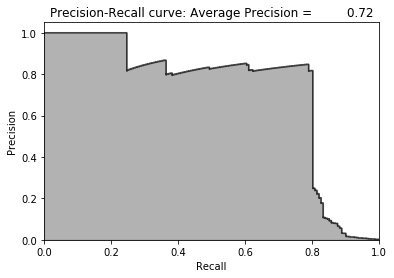

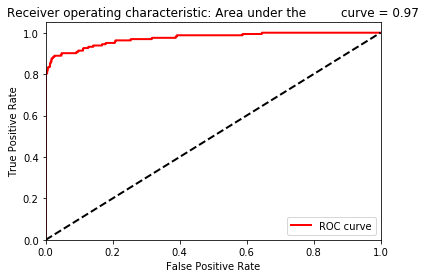

Mean average precision over 10 runs:  0.33109452600564715


[0.36545520860557545,
 0.7032681561472861,
 0.3024772328733294,
 0.09526462304550994,
 0.035168144788274736,
 0.03601997796208239,
 0.586476176169929,
 0.06757918222589387,
 0.39711031677711883,
 0.722126241461472]

In [25]:
# Model seven
# Two layer sparse overcomplete autoencoder with linear activation
# 29 -> 40 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [26]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.33109452600564715
Coefficient of variation over 10 runs:  0.7775073675570532


[0.36545520860557545,
 0.7032681561472861,
 0.3024772328733294,
 0.09526462304550994,
 0.035168144788274736,
 0.03601997796208239,
 0.586476176169929,
 0.06757918222589387,
 0.39711031677711883,
 0.722126241461472]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.1438 - acc: 0.8212 - val_loss: 0.0457 - val_acc: 0.9835
Epoch 2/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0742 - acc: 0.8621 - val_loss: 0.0331 - val_acc: 0.9828
Epoch 3/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0674 - acc: 0.8619 - val_loss: 0.0283 - val_acc: 0.9776
Epoch 4/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0666 - acc: 0.8595 - val_loss: 0.0266 - val_acc: 0.9678
Epoch 5/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0617 - acc: 0.8607 - val_loss: 0.0232 - val_acc: 0.9790
Epoch 6/10
190820/190820 [==============================] - 24s 125us/step - loss: 0.0602 - acc: 0.8612 - val_loss: 0.0236 - val_acc: 0.9743
Epoch 7/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0645 - acc: 0.857

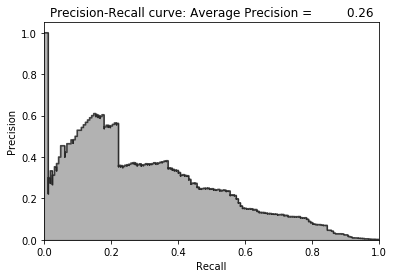

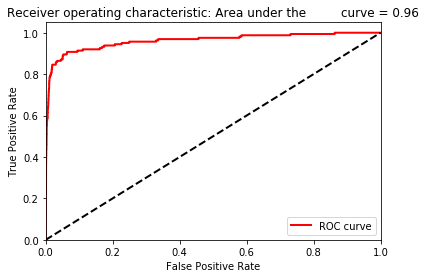

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.1650 - acc: 0.8074 - val_loss: 0.0500 - val_acc: 0.9785
Epoch 2/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0784 - acc: 0.8607 - val_loss: 0.0361 - val_acc: 0.9803
Epoch 3/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0698 - acc: 0.8616 - val_loss: 0.0300 - val_acc: 0.9784
Epoch 4/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0655 - acc: 0.8592 - val_loss: 0.0259 - val_acc: 0.9841
Epoch 5/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0624 - acc: 0.8585 - val_loss: 0.0325 - val_acc: 0.9448
Epoch 6/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0606 - acc: 0.8564 - val_loss: 0.0223 - val_acc: 0.9787
Epoch 7/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0610 - acc: 0.857

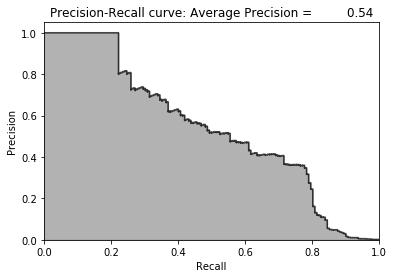

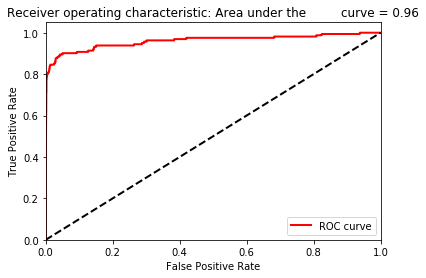

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1671 - acc: 0.8069 - val_loss: 0.0592 - val_acc: 0.9629
Epoch 2/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0762 - acc: 0.8635 - val_loss: 0.0366 - val_acc: 0.9721
Epoch 3/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0676 - acc: 0.8625 - val_loss: 0.0324 - val_acc: 0.9729
Epoch 4/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0647 - acc: 0.8595 - val_loss: 0.0253 - val_acc: 0.9816
Epoch 5/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0620 - acc: 0.8608 - val_loss: 0.0247 - val_acc: 0.9715
Epoch 6/10
190820/190820 [==============================] - 22s 113us/step - loss: 0.0593 - acc: 0.8591 - val_loss: 0.0224 - val_acc: 0.9670
Epoch 7/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0599 - acc: 0.859

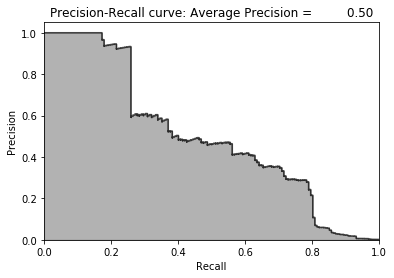

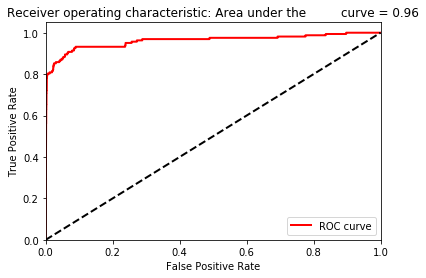

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1703 - acc: 0.8024 - val_loss: 0.0492 - val_acc: 0.9814
Epoch 2/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0782 - acc: 0.8611 - val_loss: 0.0433 - val_acc: 0.9581
Epoch 3/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0692 - acc: 0.8619 - val_loss: 0.0297 - val_acc: 0.9768
Epoch 4/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0650 - acc: 0.8626 - val_loss: 0.0274 - val_acc: 0.9722
Epoch 5/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0626 - acc: 0.8600 - val_loss: 0.0253 - val_acc: 0.9737
Epoch 6/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0624 - acc: 0.8599 - val_loss: 0.0220 - val_acc: 0.9769
Epoch 7/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0625 - acc: 0.861

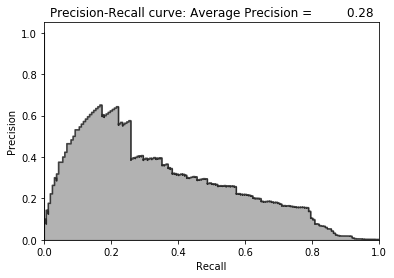

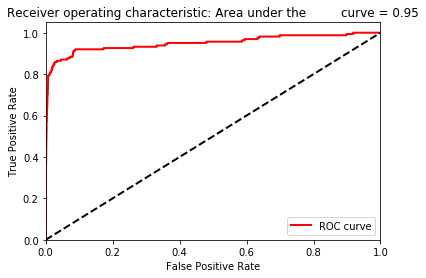

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.1475 - acc: 0.8207 - val_loss: 0.0481 - val_acc: 0.9725
Epoch 2/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0759 - acc: 0.8624 - val_loss: 0.0339 - val_acc: 0.9830
Epoch 3/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0692 - acc: 0.8611 - val_loss: 0.0302 - val_acc: 0.9762
Epoch 4/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0640 - acc: 0.8604 - val_loss: 0.0300 - val_acc: 0.9665
Epoch 5/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0633 - acc: 0.8590 - val_loss: 0.0230 - val_acc: 0.9826
Epoch 6/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0605 - acc: 0.8596 - val_loss: 0.0227 - val_acc: 0.9822
Epoch 7/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0595 - acc: 0.859

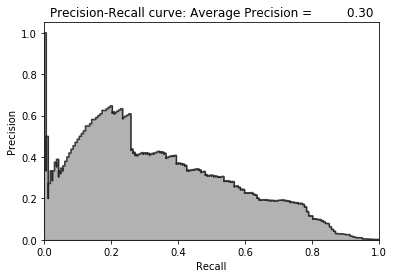

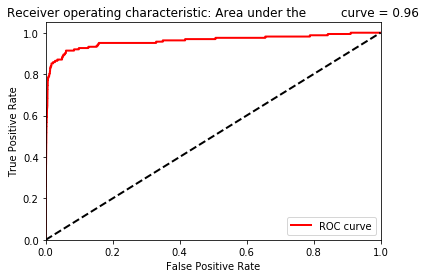

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1620 - acc: 0.8125 - val_loss: 0.0506 - val_acc: 0.9781
Epoch 2/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0781 - acc: 0.8622 - val_loss: 0.0368 - val_acc: 0.9796
Epoch 3/10
190820/190820 [==============================] - 22s 118us/step - loss: 0.0686 - acc: 0.8619 - val_loss: 0.0319 - val_acc: 0.9826
Epoch 4/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0656 - acc: 0.8613 - val_loss: 0.0262 - val_acc: 0.9798
Epoch 5/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0639 - acc: 0.8618 - val_loss: 0.0236 - val_acc: 0.9841
Epoch 6/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0613 - acc: 0.8625 - val_loss: 0.0243 - val_acc: 0.9655
Epoch 7/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0609 - acc: 0.860

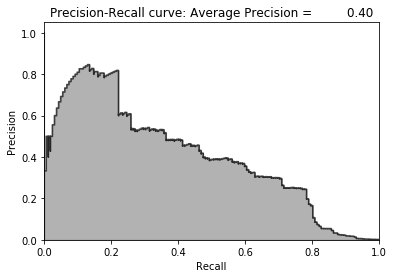

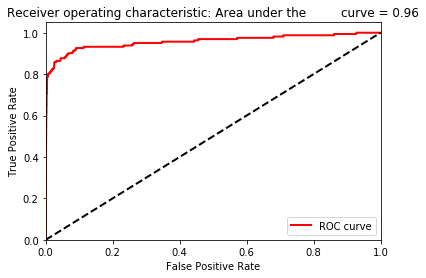

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.2023 - acc: 0.7760 - val_loss: 0.0551 - val_acc: 0.9705
Epoch 2/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0805 - acc: 0.8630 - val_loss: 0.0371 - val_acc: 0.9799
Epoch 3/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0719 - acc: 0.8621 - val_loss: 0.0310 - val_acc: 0.9752
Epoch 4/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0655 - acc: 0.8623 - val_loss: 0.0274 - val_acc: 0.9804
Epoch 5/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0636 - acc: 0.8613 - val_loss: 0.0267 - val_acc: 0.9668
Epoch 6/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0605 - acc: 0.8613 - val_loss: 0.0251 - val_acc: 0.9710
Epoch 7/10
190820/190820 [==============================] - 22s 118us/step - loss: 0.0609 - acc: 0.861

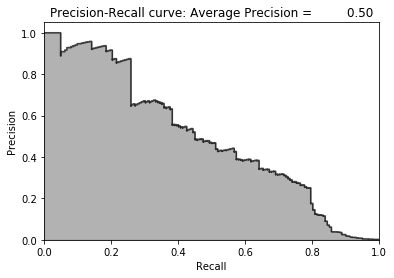

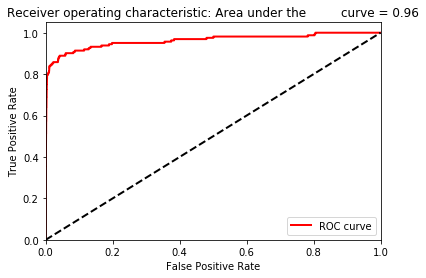

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1704 - acc: 0.8054 - val_loss: 0.0495 - val_acc: 0.9767
Epoch 2/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0794 - acc: 0.8621 - val_loss: 0.0370 - val_acc: 0.9730
Epoch 3/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0683 - acc: 0.8633 - val_loss: 0.0360 - val_acc: 0.9642
Epoch 4/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0655 - acc: 0.8626 - val_loss: 0.0277 - val_acc: 0.9749
Epoch 5/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0647 - acc: 0.8600 - val_loss: 0.0239 - val_acc: 0.9842
Epoch 6/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0617 - acc: 0.8605 - val_loss: 0.0225 - val_acc: 0.9809
Epoch 7/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0611 - acc: 0.859

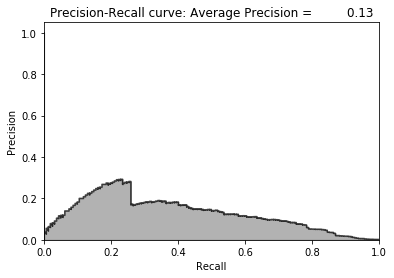

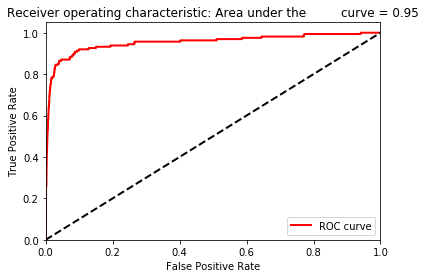

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1666 - acc: 0.8046 - val_loss: 0.0485 - val_acc: 0.9781
Epoch 2/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0770 - acc: 0.8629 - val_loss: 0.0368 - val_acc: 0.9720
Epoch 3/10
190820/190820 [==============================] - 22s 118us/step - loss: 0.0683 - acc: 0.8621 - val_loss: 0.0296 - val_acc: 0.9750
Epoch 4/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0656 - acc: 0.8610 - val_loss: 0.0277 - val_acc: 0.9748
Epoch 5/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0618 - acc: 0.8609 - val_loss: 0.0249 - val_acc: 0.9772
Epoch 6/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0616 - acc: 0.8588 - val_loss: 0.0245 - val_acc: 0.9789
Epoch 7/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0594 - acc: 0.860

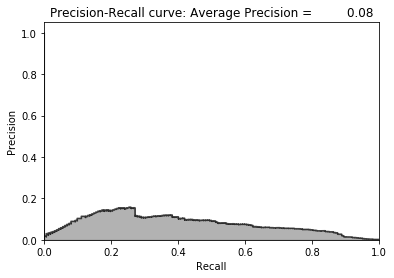

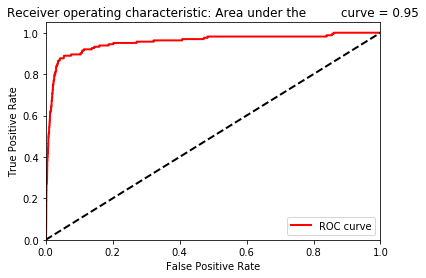

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1616 - acc: 0.8093 - val_loss: 0.0481 - val_acc: 0.9743
Epoch 2/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0758 - acc: 0.8634 - val_loss: 0.0361 - val_acc: 0.9784
Epoch 3/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0679 - acc: 0.8629 - val_loss: 0.0295 - val_acc: 0.9763
Epoch 4/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0650 - acc: 0.8624 - val_loss: 0.0265 - val_acc: 0.9753
Epoch 5/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0623 - acc: 0.8623 - val_loss: 0.0390 - val_acc: 0.9406
Epoch 6/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0613 - acc: 0.8603 - val_loss: 0.0272 - val_acc: 0.9676
Epoch 7/10
190820/190820 [==============================] - 23s 118us/step - loss: 0.0618 - acc: 0.861

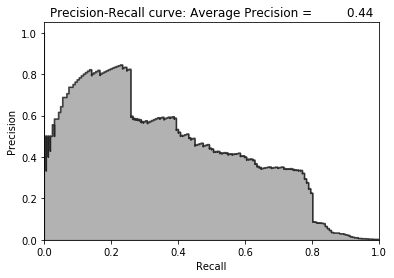

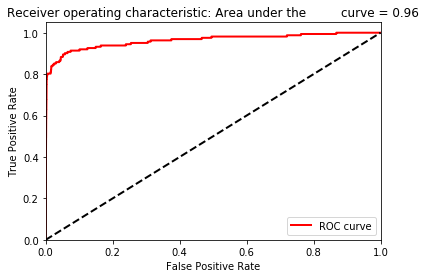

Mean average precision over 10 runs:  0.3438671662839782


[0.2632442056485647,
 0.5429674656340842,
 0.5012821010891244,
 0.27933673960648814,
 0.30245458791758506,
 0.4045607586421209,
 0.4985426875498758,
 0.12830128068086216,
 0.07799119623408482,
 0.4399906398369911]

In [27]:
# Model eight
# Two layer sparse overcomplete autoencoder with linear activation and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [28]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.3438671662839782
Coefficient of variation over 10 runs:  0.4418075018272789


[0.2632442056485647,
 0.5429674656340842,
 0.5012821010891244,
 0.27933673960648814,
 0.30245458791758506,
 0.4045607586421209,
 0.4985426875498758,
 0.12830128068086216,
 0.07799119623408482,
 0.4399906398369911]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1419 - acc: 0.7774 - val_loss: 0.0360 - val_acc: 0.8579
Epoch 2/10
190820/190820 [==============================] - 22s 116us/step - loss: 0.0545 - acc: 0.8523 - val_loss: 0.0355 - val_acc: 0.8854
Epoch 3/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0542 - acc: 0.8578 - val_loss: 0.0353 - val_acc: 0.9084
Epoch 4/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0534 - acc: 0.8775 - val_loss: 0.0359 - val_acc: 0.8965
Epoch 5/10
190820/190820 [==============================] - 22s 115us/step - loss: 0.0530 - acc: 0.8773 - val_loss: 0.0339 - val_acc: 0.9473
Epoch 6/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0527 - acc: 0.8876 - val_loss: 0.0339 - val_acc: 0.9383
Epoch 7/10
190820/190820 [==============================] - 22s 114us/step - loss: 0.0523 - acc: 0.886

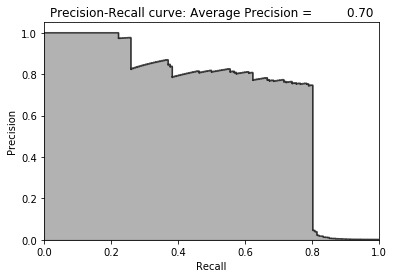

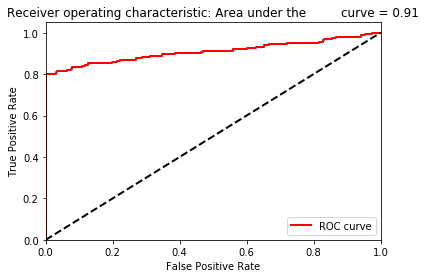

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.1433 - acc: 0.7880 - val_loss: 0.0358 - val_acc: 0.9090
Epoch 2/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0562 - acc: 0.8715 - val_loss: 0.0355 - val_acc: 0.9113
Epoch 3/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0547 - acc: 0.8761 - val_loss: 0.0354 - val_acc: 0.9222
Epoch 4/10
190820/190820 [==============================] - 22s 117us/step - loss: 0.0529 - acc: 0.8796 - val_loss: 0.0355 - val_acc: 0.9505
Epoch 5/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0535 - acc: 0.8875 - val_loss: 0.0364 - val_acc: 0.9391
Epoch 6/10
190820/190820 [==============================] - 23s 123us/step - loss: 0.0551 - acc: 0.8904 - val_loss: 0.0360 - val_acc: 0.9376
Epoch 7/10
190820/190820 [==============================] - 24s 125us/step - loss: 0.0548 - acc: 0.888

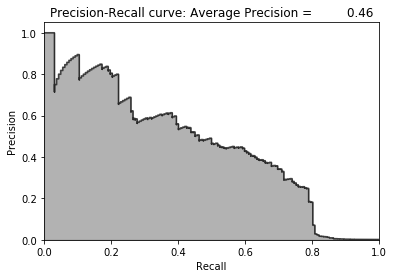

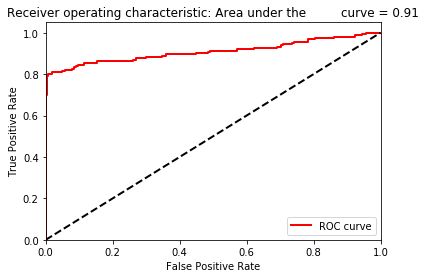

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.1403 - acc: 0.8017 - val_loss: 0.0368 - val_acc: 0.8849
Epoch 2/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.0574 - acc: 0.8738 - val_loss: 0.0367 - val_acc: 0.9157
Epoch 3/10
190820/190820 [==============================] - 24s 123us/step - loss: 0.0545 - acc: 0.8827 - val_loss: 0.0362 - val_acc: 0.9535
Epoch 4/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0555 - acc: 0.9053 - val_loss: 0.0368 - val_acc: 0.9495
Epoch 5/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0554 - acc: 0.9068 - val_loss: 0.0371 - val_acc: 0.9509
Epoch 6/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0554 - acc: 0.9091 - val_loss: 0.0366 - val_acc: 0.9604
Epoch 7/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0553 - acc: 0.912

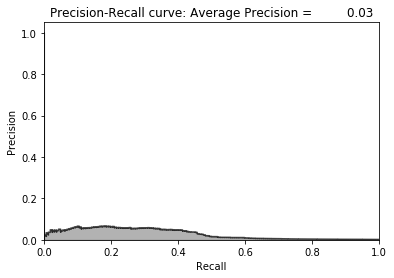

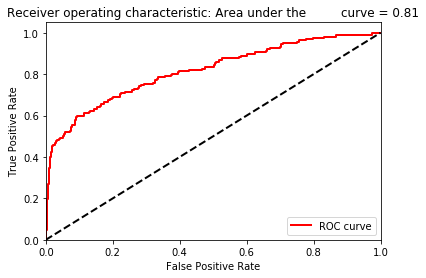

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 159us/step - loss: 0.1399 - acc: 0.7635 - val_loss: 0.0365 - val_acc: 0.8691
Epoch 2/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0566 - acc: 0.8670 - val_loss: 0.0360 - val_acc: 0.8932
Epoch 3/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0579 - acc: 0.8758 - val_loss: 0.0380 - val_acc: 0.9347
Epoch 4/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0565 - acc: 0.8958 - val_loss: 0.0374 - val_acc: 0.9499
Epoch 5/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.0554 - acc: 0.8917 - val_loss: 0.0368 - val_acc: 0.9554
Epoch 6/10
190820/190820 [==============================] - 24s 123us/step - loss: 0.0556 - acc: 0.9075 - val_loss: 0.0368 - val_acc: 0.9538
Epoch 7/10
190820/190820 [==============================] - 24s 123us/step - loss: 0.0556 - acc: 0.909

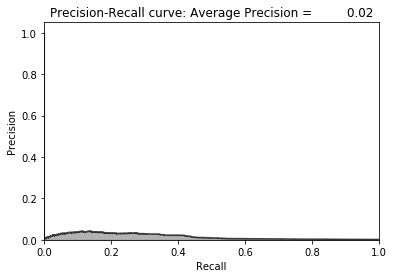

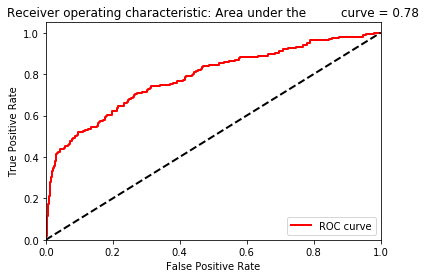

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 156us/step - loss: 0.1340 - acc: 0.7682 - val_loss: 0.0365 - val_acc: 0.8993
Epoch 2/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0570 - acc: 0.8868 - val_loss: 0.0365 - val_acc: 0.9440
Epoch 3/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0558 - acc: 0.8983 - val_loss: 0.0368 - val_acc: 0.9599
Epoch 4/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0566 - acc: 0.9032 - val_loss: 0.0374 - val_acc: 0.9429
Epoch 5/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0569 - acc: 0.8933 - val_loss: 0.0373 - val_acc: 0.9425
Epoch 6/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0559 - acc: 0.9047 - val_loss: 0.0366 - val_acc: 0.9629
Epoch 7/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0554 - acc: 0.911

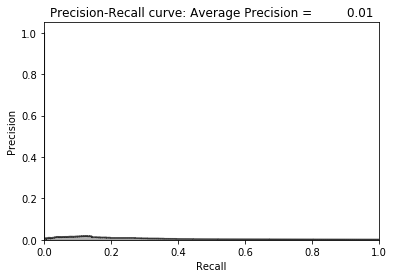

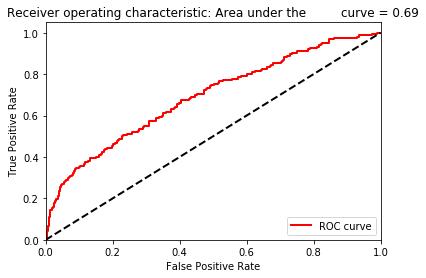

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 161us/step - loss: 0.1387 - acc: 0.7910 - val_loss: 0.0362 - val_acc: 0.8733
Epoch 2/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0539 - acc: 0.8632 - val_loss: 0.0372 - val_acc: 0.9383
Epoch 3/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0573 - acc: 0.8773 - val_loss: 0.0367 - val_acc: 0.9463
Epoch 4/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0567 - acc: 0.8818 - val_loss: 0.0360 - val_acc: 0.9342
Epoch 5/10
190820/190820 [==============================] - 23s 119us/step - loss: 0.0547 - acc: 0.8858 - val_loss: 0.0377 - val_acc: 0.9407
Epoch 6/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0565 - acc: 0.8951 - val_loss: 0.0365 - val_acc: 0.9439
Epoch 7/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0554 - acc: 0.898

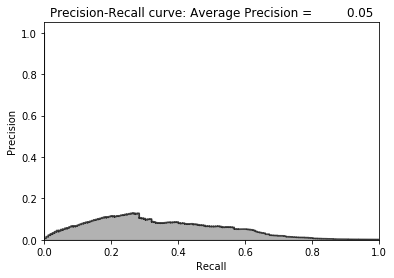

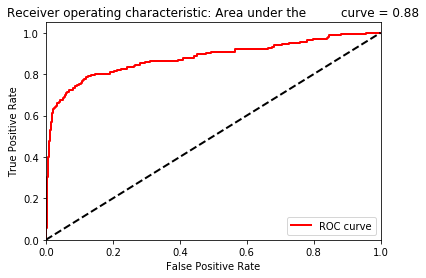

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.1351 - acc: 0.8061 - val_loss: 0.0364 - val_acc: 0.9162
Epoch 2/10
190820/190820 [==============================] - 23s 123us/step - loss: 0.0561 - acc: 0.8912 - val_loss: 0.0368 - val_acc: 0.9424
Epoch 3/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0563 - acc: 0.9072 - val_loss: 0.0364 - val_acc: 0.9566
Epoch 4/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0549 - acc: 0.9180 - val_loss: 0.0369 - val_acc: 0.9562
Epoch 5/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0553 - acc: 0.9114 - val_loss: 0.0383 - val_acc: 0.9561
Epoch 6/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0559 - acc: 0.9093 - val_loss: 0.0370 - val_acc: 0.9628
Epoch 7/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0562 - acc: 0.902

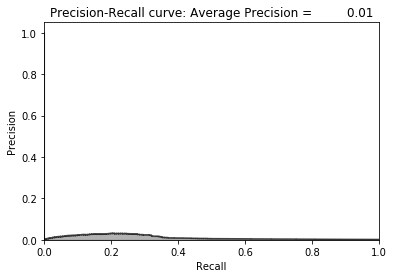

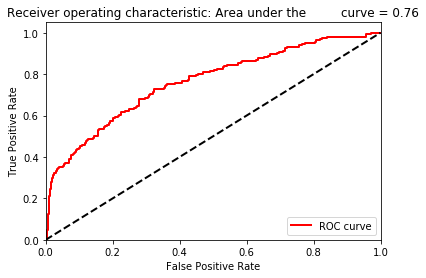

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 30s 157us/step - loss: 0.1345 - acc: 0.8179 - val_loss: 0.0368 - val_acc: 0.9140
Epoch 2/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0536 - acc: 0.8810 - val_loss: 0.0345 - val_acc: 0.9423
Epoch 3/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0528 - acc: 0.8842 - val_loss: 0.0345 - val_acc: 0.9373
Epoch 4/10
190820/190820 [==============================] - 23s 122us/step - loss: 0.0523 - acc: 0.8861 - val_loss: 0.0348 - val_acc: 0.9410
Epoch 5/10
190820/190820 [==============================] - 23s 123us/step - loss: 0.0535 - acc: 0.8877 - val_loss: 0.0342 - val_acc: 0.9473
Epoch 6/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0523 - acc: 0.8830 - val_loss: 0.0369 - val_acc: 0.9548
Epoch 7/10
190820/190820 [==============================] - 24s 124us/step - loss: 0.0527 - acc: 0.888

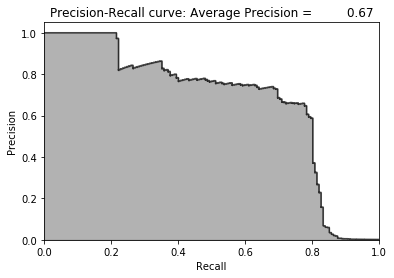

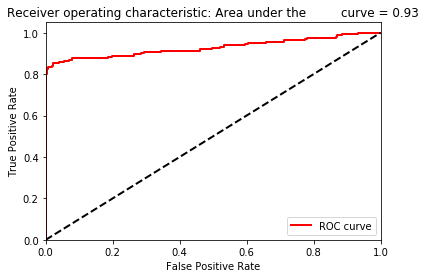

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 29s 153us/step - loss: 0.2079 - acc: 0.7463 - val_loss: 0.0368 - val_acc: 0.9052
Epoch 2/10
190820/190820 [==============================] - 23s 120us/step - loss: 0.0570 - acc: 0.8865 - val_loss: 0.0363 - val_acc: 0.9393
Epoch 3/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0568 - acc: 0.8957 - val_loss: 0.0366 - val_acc: 0.9437
Epoch 4/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0564 - acc: 0.9084 - val_loss: 0.0368 - val_acc: 0.9603
Epoch 5/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0562 - acc: 0.9133 - val_loss: 0.0365 - val_acc: 0.9607
Epoch 6/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0553 - acc: 0.9134 - val_loss: 0.0367 - val_acc: 0.9619
Epoch 7/10
190820/190820 [==============================] - 23s 121us/step - loss: 0.0560 - acc: 0.908

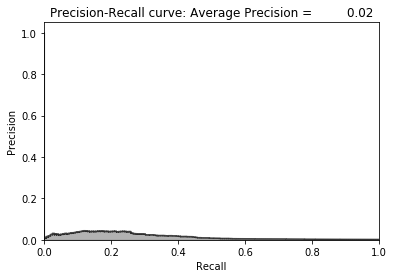

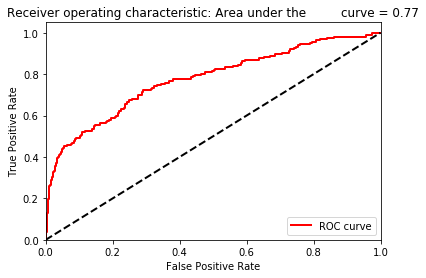

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 164us/step - loss: 0.1420 - acc: 0.7920 - val_loss: 0.0372 - val_acc: 0.9311
Epoch 2/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0565 - acc: 0.8958 - val_loss: 0.0370 - val_acc: 0.9534
Epoch 3/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0564 - acc: 0.9082 - val_loss: 0.0366 - val_acc: 0.9555
Epoch 4/10
190820/190820 [==============================] - 24s 128us/step - loss: 0.0557 - acc: 0.9062 - val_loss: 0.0374 - val_acc: 0.9548
Epoch 5/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0558 - acc: 0.9081 - val_loss: 0.0370 - val_acc: 0.9627
Epoch 6/10
190820/190820 [==============================] - 24s 126us/step - loss: 0.0555 - acc: 0.9143 - val_loss: 0.0364 - val_acc: 0.9630
Epoch 7/10
190820/190820 [==============================] - 24s 127us/step - loss: 0.0554 - acc: 0.913

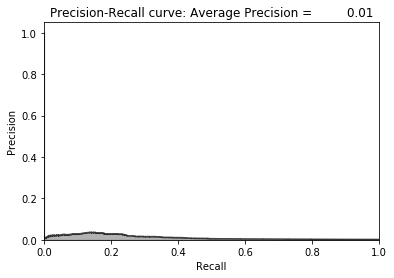

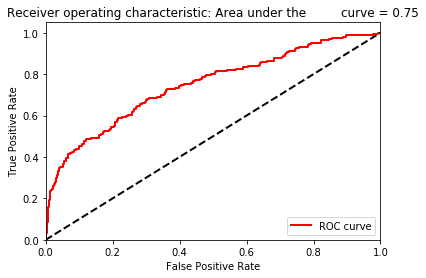

Mean average precision over 10 runs:  0.19753715700639501


[0.6967202495495949,
 0.46234975174371346,
 0.028259174462415097,
 0.01571273981153653,
 0.005947546438558479,
 0.05363890470642375,
 0.01118779695981061,
 0.6742305044772064,
 0.015874083651763883,
 0.011450818262926868]

In [29]:
# Model nine
# Two layer denoising undercomplete autoencoder with linear activation
# 29 -> 27 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [30]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.19753715700639501
Coefficient of variation over 10 runs:  1.402943988671825


[0.6967202495495949,
 0.46234975174371346,
 0.028259174462415097,
 0.01571273981153653,
 0.005947546438558479,
 0.05363890470642375,
 0.01118779695981061,
 0.6742305044772064,
 0.015874083651763883,
 0.011450818262926868]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 35s 181us/step - loss: 0.1916 - acc: 0.7951 - val_loss: 0.0456 - val_acc: 0.9774
Epoch 2/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0897 - acc: 0.8472 - val_loss: 0.0356 - val_acc: 0.9698
Epoch 3/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0785 - acc: 0.8475 - val_loss: 0.0257 - val_acc: 0.9809
Epoch 4/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.0761 - acc: 0.8462 - val_loss: 0.0234 - val_acc: 0.9805
Epoch 5/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0741 - acc: 0.8462 - val_loss: 0.0212 - val_acc: 0.9798
Epoch 6/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0726 - acc: 0.8448 - val_loss: 0.0200 - val_acc: 0.9792
Epoch 7/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0719 - acc: 0.843

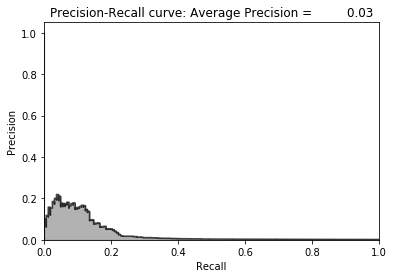

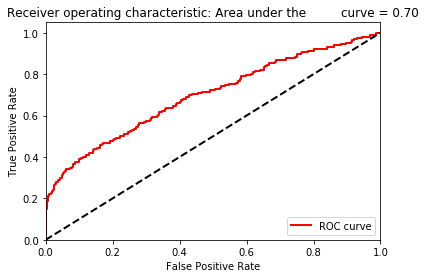

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 165us/step - loss: 0.1682 - acc: 0.8041 - val_loss: 0.0420 - val_acc: 0.9786
Epoch 2/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0880 - acc: 0.8465 - val_loss: 0.0306 - val_acc: 0.9831
Epoch 3/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.0795 - acc: 0.8483 - val_loss: 0.0259 - val_acc: 0.9786
Epoch 4/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0751 - acc: 0.8457 - val_loss: 0.0227 - val_acc: 0.9809
Epoch 5/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0730 - acc: 0.8454 - val_loss: 0.0230 - val_acc: 0.9683
Epoch 6/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0716 - acc: 0.8455 - val_loss: 0.0223 - val_acc: 0.9761
Epoch 7/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0721 - acc: 0.843

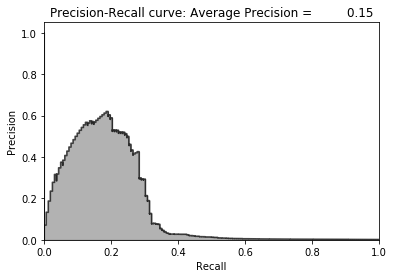

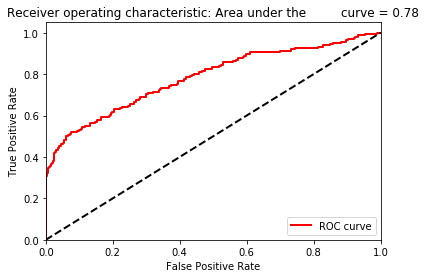

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 31s 163us/step - loss: 0.2007 - acc: 0.7900 - val_loss: 0.0488 - val_acc: 0.9755
Epoch 2/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0908 - acc: 0.8485 - val_loss: 0.0332 - val_acc: 0.9791
Epoch 3/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0805 - acc: 0.8467 - val_loss: 0.0274 - val_acc: 0.9821
Epoch 4/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0776 - acc: 0.8457 - val_loss: 0.0236 - val_acc: 0.9834
Epoch 5/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.0740 - acc: 0.8461 - val_loss: 0.0652 - val_acc: 0.9043
Epoch 6/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0738 - acc: 0.8447 - val_loss: 0.0208 - val_acc: 0.9785
Epoch 7/10
190820/190820 [==============================] - 25s 134us/step - loss: 0.0710 - acc: 0.845

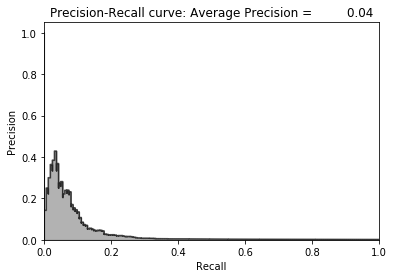

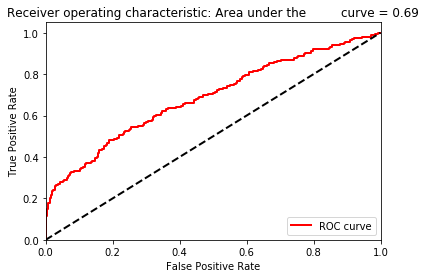

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 170us/step - loss: 0.1843 - acc: 0.7965 - val_loss: 0.0458 - val_acc: 0.9835
Epoch 2/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0907 - acc: 0.8469 - val_loss: 0.0326 - val_acc: 0.9848
Epoch 3/10
190820/190820 [==============================] - 25s 129us/step - loss: 0.0802 - acc: 0.8479 - val_loss: 0.0296 - val_acc: 0.9800
Epoch 4/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0766 - acc: 0.8449 - val_loss: 0.0280 - val_acc: 0.9595
Epoch 5/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.0747 - acc: 0.8437 - val_loss: 0.0216 - val_acc: 0.9797
Epoch 6/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0748 - acc: 0.8433 - val_loss: 0.0208 - val_acc: 0.9815
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0727 - acc: 0.844

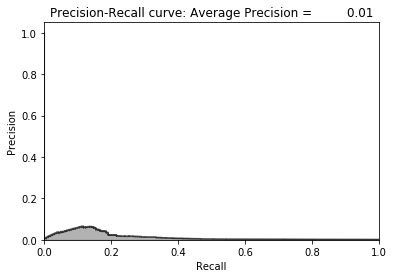

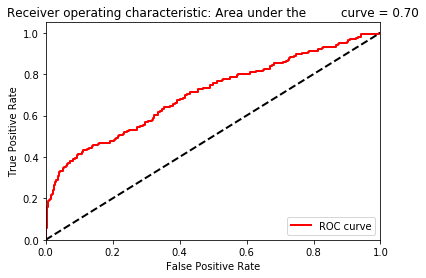

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 168us/step - loss: 0.1811 - acc: 0.8018 - val_loss: 0.0446 - val_acc: 0.9827
Epoch 2/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0891 - acc: 0.8483 - val_loss: 0.0347 - val_acc: 0.9689
Epoch 3/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.0814 - acc: 0.8466 - val_loss: 0.0268 - val_acc: 0.9790
Epoch 4/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0752 - acc: 0.8465 - val_loss: 0.0279 - val_acc: 0.9728
Epoch 5/10
190820/190820 [==============================] - 25s 130us/step - loss: 0.0731 - acc: 0.8454 - val_loss: 0.0228 - val_acc: 0.9729
Epoch 6/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.0736 - acc: 0.8436 - val_loss: 0.0206 - val_acc: 0.9791
Epoch 7/10
190820/190820 [==============================] - 25s 132us/step - loss: 0.0732 - acc: 0.843

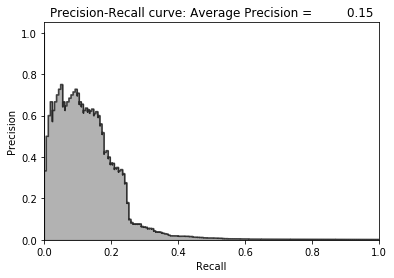

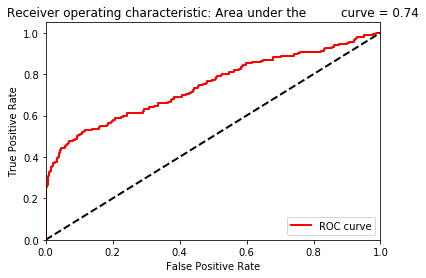

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 33s 172us/step - loss: 0.2068 - acc: 0.7845 - val_loss: 0.0477 - val_acc: 0.9788
Epoch 2/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0924 - acc: 0.8473 - val_loss: 0.0331 - val_acc: 0.9859
Epoch 3/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0814 - acc: 0.8466 - val_loss: 0.0272 - val_acc: 0.9809
Epoch 4/10
190820/190820 [==============================] - 25s 131us/step - loss: 0.0776 - acc: 0.8479 - val_loss: 0.0238 - val_acc: 0.9836
Epoch 5/10
190820/190820 [==============================] - 25s 128us/step - loss: 0.0738 - acc: 0.8450 - val_loss: 0.0217 - val_acc: 0.9845
Epoch 6/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0718 - acc: 0.8471 - val_loss: 0.0251 - val_acc: 0.9698
Epoch 7/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0709 - acc: 0.844

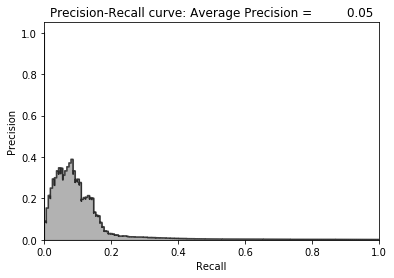

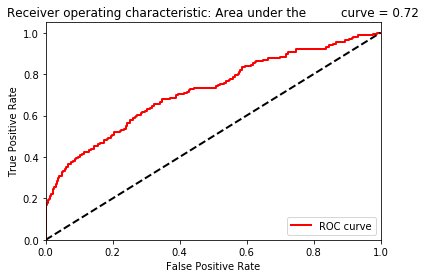

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 34s 179us/step - loss: 0.1758 - acc: 0.7997 - val_loss: 0.0442 - val_acc: 0.9761
Epoch 2/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0887 - acc: 0.8464 - val_loss: 0.0331 - val_acc: 0.9772
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0805 - acc: 0.8453 - val_loss: 0.0265 - val_acc: 0.9781
Epoch 4/10
190820/190820 [==============================] - 27s 144us/step - loss: 0.0774 - acc: 0.8456 - val_loss: 0.0240 - val_acc: 0.9801
Epoch 5/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0746 - acc: 0.8447 - val_loss: 0.0231 - val_acc: 0.9733
Epoch 6/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.0725 - acc: 0.8436 - val_loss: 0.0215 - val_acc: 0.9709
Epoch 7/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0742 - acc: 0.842

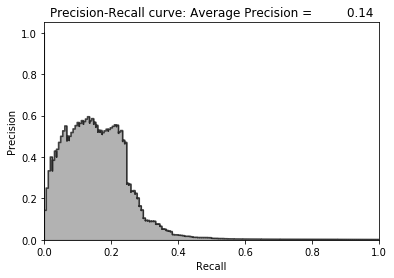

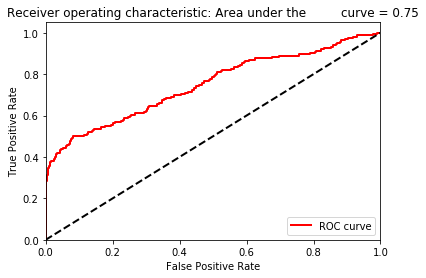

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 36s 187us/step - loss: 0.2121 - acc: 0.7823 - val_loss: 0.0478 - val_acc: 0.9852
Epoch 2/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0918 - acc: 0.8484 - val_loss: 0.0354 - val_acc: 0.9769
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0807 - acc: 0.8480 - val_loss: 0.0334 - val_acc: 0.9686
Epoch 4/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.0771 - acc: 0.8465 - val_loss: 0.0239 - val_acc: 0.9807
Epoch 5/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.0751 - acc: 0.8465 - val_loss: 0.0218 - val_acc: 0.9828
Epoch 6/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.0735 - acc: 0.8451 - val_loss: 0.0217 - val_acc: 0.9784
Epoch 7/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.0719 - acc: 0.846

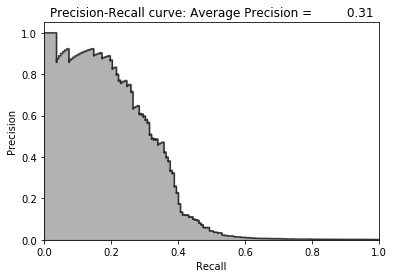

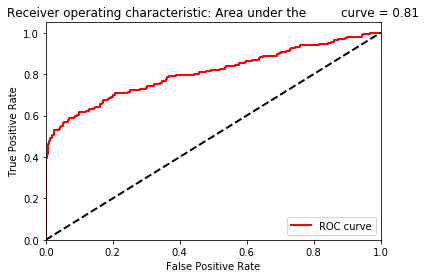

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 169us/step - loss: 0.1731 - acc: 0.8047 - val_loss: 0.0434 - val_acc: 0.9809
Epoch 2/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0889 - acc: 0.8470 - val_loss: 0.0338 - val_acc: 0.9755
Epoch 3/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0800 - acc: 0.8462 - val_loss: 0.0287 - val_acc: 0.9665
Epoch 4/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0780 - acc: 0.8457 - val_loss: 0.0255 - val_acc: 0.9833
Epoch 5/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.0733 - acc: 0.8457 - val_loss: 0.0226 - val_acc: 0.9773
Epoch 6/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0727 - acc: 0.8448 - val_loss: 0.0200 - val_acc: 0.9825
Epoch 7/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0714 - acc: 0.843

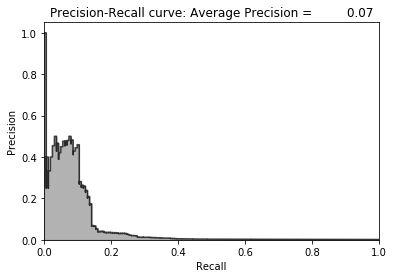

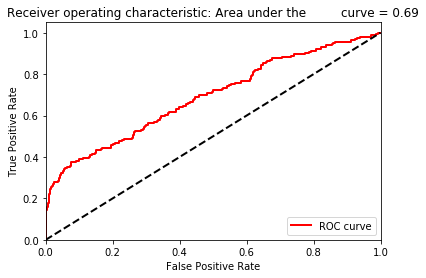

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 32s 170us/step - loss: 0.1712 - acc: 0.8064 - val_loss: 0.0465 - val_acc: 0.9773
Epoch 2/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.0892 - acc: 0.8484 - val_loss: 0.0325 - val_acc: 0.9810
Epoch 3/10
190820/190820 [==============================] - 25s 133us/step - loss: 0.0816 - acc: 0.8481 - val_loss: 0.0272 - val_acc: 0.9802
Epoch 4/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.0760 - acc: 0.8455 - val_loss: 0.0246 - val_acc: 0.9751
Epoch 5/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.0746 - acc: 0.8446 - val_loss: 0.0223 - val_acc: 0.9777
Epoch 6/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.0733 - acc: 0.8445 - val_loss: 0.0220 - val_acc: 0.9758
Epoch 7/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.0713 - acc: 0.844

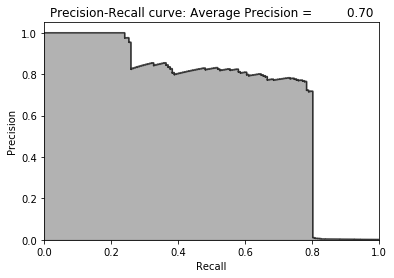

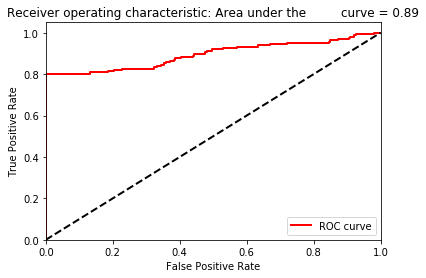

Mean average precision over 10 runs:  0.16535732603246572


[0.03212329390181818,
 0.14931447092616976,
 0.03567758633537426,
 0.01365057150129918,
 0.1498167049334691,
 0.04890118656129334,
 0.14488070967387343,
 0.3133513963877576,
 0.067058908237278,
 0.6987984318663245]

In [31]:
# Model ten
# Two layer denoising overcomplete autoencoder with linear activation
# And sparsity regularizer and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [32]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.16535732603246572
Coefficient of variation over 10 runs:  1.1915090564582462


[0.03212329390181818,
 0.14931447092616976,
 0.03567758633537426,
 0.01365057150129918,
 0.1498167049334691,
 0.04890118656129334,
 0.14488070967387343,
 0.3133513963877576,
 0.067058908237278,
 0.6987984318663245]

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 35s 181us/step - loss: 0.2995 - acc: 0.6459 - val_loss: 0.0835 - val_acc: 0.8909
Epoch 2/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1825 - acc: 0.7176 - val_loss: 0.0615 - val_acc: 0.8992
Epoch 3/10
190820/190820 [==============================] - 26s 134us/step - loss: 0.1705 - acc: 0.7225 - val_loss: 0.0527 - val_acc: 0.9039
Epoch 4/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1612 - acc: 0.7251 - val_loss: 0.0596 - val_acc: 0.8728
Epoch 5/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1534 - acc: 0.7275 - val_loss: 0.0447 - val_acc: 0.8992
Epoch 6/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1477 - acc: 0.7324 - val_loss: 0.0386 - val_acc: 0.9139
Epoch 7/10
190820/190820 [==============================] - 26s 135us/step - loss: 0.1440 - acc: 0.732

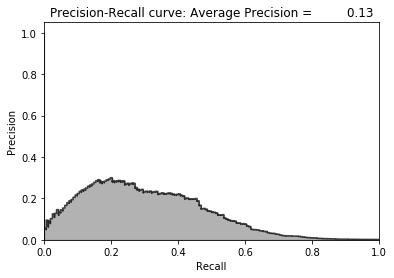

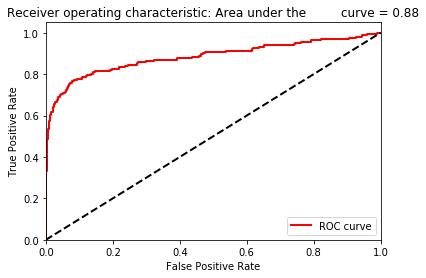

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 35s 183us/step - loss: 0.3089 - acc: 0.6388 - val_loss: 0.0860 - val_acc: 0.8745
Epoch 2/10
190820/190820 [==============================] - 26s 136us/step - loss: 0.1861 - acc: 0.7107 - val_loss: 0.0638 - val_acc: 0.8901
Epoch 3/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1674 - acc: 0.7161 - val_loss: 0.0516 - val_acc: 0.8996
Epoch 4/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.1552 - acc: 0.7215 - val_loss: 0.0456 - val_acc: 0.8989
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1489 - acc: 0.7261 - val_loss: 0.0429 - val_acc: 0.8971
Epoch 6/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1434 - acc: 0.7297 - val_loss: 0.0378 - val_acc: 0.9105
Epoch 7/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1434 - acc: 0.730

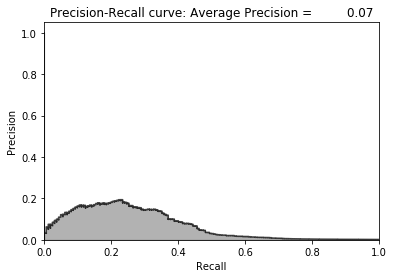

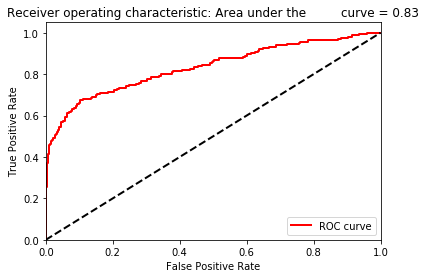

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 34s 179us/step - loss: 0.3167 - acc: 0.6359 - val_loss: 0.0880 - val_acc: 0.8756
Epoch 2/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.1882 - acc: 0.7107 - val_loss: 0.0692 - val_acc: 0.8878
Epoch 3/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.1713 - acc: 0.7197 - val_loss: 0.0562 - val_acc: 0.9021
Epoch 4/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1623 - acc: 0.7240 - val_loss: 0.0479 - val_acc: 0.9111
Epoch 5/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1533 - acc: 0.7265 - val_loss: 0.0429 - val_acc: 0.9168
Epoch 6/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1473 - acc: 0.7284 - val_loss: 0.0404 - val_acc: 0.9124
Epoch 7/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.1447 - acc: 0.728

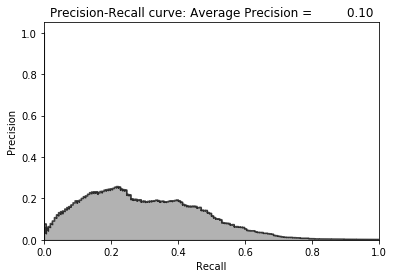

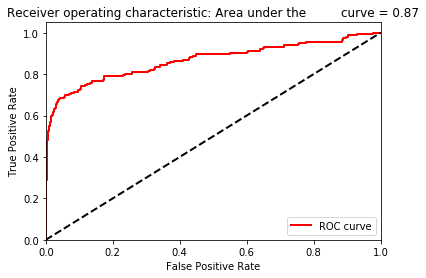

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 35s 182us/step - loss: 0.2941 - acc: 0.6490 - val_loss: 0.0821 - val_acc: 0.8917
Epoch 2/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1811 - acc: 0.7165 - val_loss: 0.0613 - val_acc: 0.9032
Epoch 3/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1613 - acc: 0.7236 - val_loss: 0.0519 - val_acc: 0.9091
Epoch 4/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.1511 - acc: 0.7252 - val_loss: 0.0433 - val_acc: 0.9131
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1468 - acc: 0.7283 - val_loss: 0.0426 - val_acc: 0.9121
Epoch 6/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1423 - acc: 0.7299 - val_loss: 0.0362 - val_acc: 0.9138
Epoch 7/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1404 - acc: 0.731

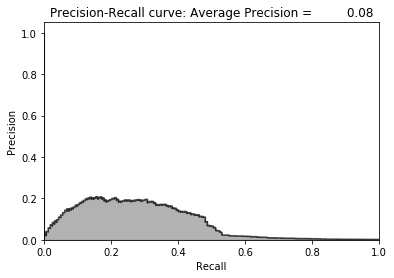

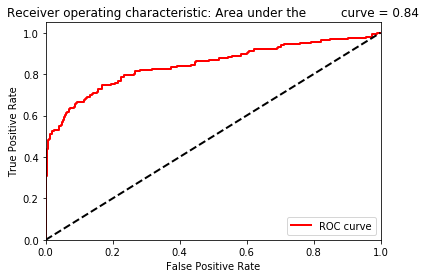

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 33s 175us/step - loss: 0.3079 - acc: 0.6448 - val_loss: 0.0869 - val_acc: 0.8889
Epoch 2/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1874 - acc: 0.7180 - val_loss: 0.0640 - val_acc: 0.8944
Epoch 3/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1657 - acc: 0.7250 - val_loss: 0.0556 - val_acc: 0.8926
Epoch 4/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1577 - acc: 0.7275 - val_loss: 0.0450 - val_acc: 0.9037
Epoch 5/10
190820/190820 [==============================] - 26s 138us/step - loss: 0.1508 - acc: 0.7275 - val_loss: 0.0421 - val_acc: 0.9038
Epoch 6/10
190820/190820 [==============================] - 26s 137us/step - loss: 0.1484 - acc: 0.7283 - val_loss: 0.0414 - val_acc: 0.9026
Epoch 7/10
190820/190820 [==============================] - 26s 139us/step - loss: 0.1490 - acc: 0.729

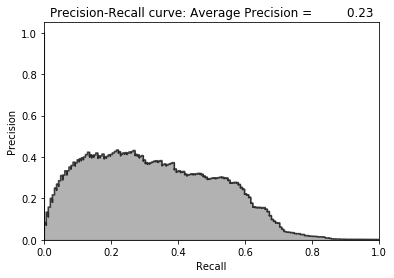

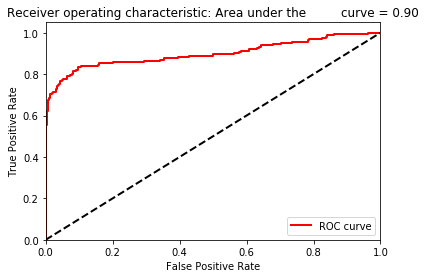

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 33s 172us/step - loss: 0.3134 - acc: 0.6423 - val_loss: 0.0841 - val_acc: 0.8833
Epoch 2/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.1854 - acc: 0.7151 - val_loss: 0.0632 - val_acc: 0.8945
Epoch 3/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.1661 - acc: 0.7227 - val_loss: 0.0520 - val_acc: 0.9018
Epoch 4/10
190820/190820 [==============================] - 27s 139us/step - loss: 0.1574 - acc: 0.7246 - val_loss: 0.0461 - val_acc: 0.8992
Epoch 5/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.1524 - acc: 0.7234 - val_loss: 0.0451 - val_acc: 0.8972
Epoch 6/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1464 - acc: 0.7272 - val_loss: 0.0393 - val_acc: 0.9088
Epoch 7/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1438 - acc: 0.727

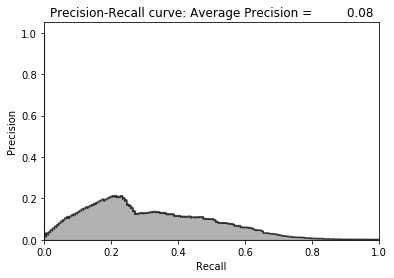

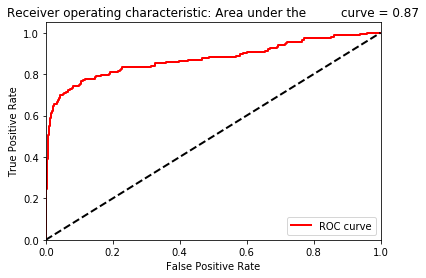

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 39s 204us/step - loss: 0.3094 - acc: 0.6448 - val_loss: 0.0872 - val_acc: 0.8876
Epoch 2/10
190820/190820 [==============================] - 29s 150us/step - loss: 0.1882 - acc: 0.7185 - val_loss: 0.0638 - val_acc: 0.9024
Epoch 3/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.1677 - acc: 0.7243 - val_loss: 0.0582 - val_acc: 0.8940
Epoch 4/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.1563 - acc: 0.7247 - val_loss: 0.0457 - val_acc: 0.9095
Epoch 5/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1502 - acc: 0.7261 - val_loss: 0.0415 - val_acc: 0.9116
Epoch 6/10
190820/190820 [==============================] - 28s 149us/step - loss: 0.1463 - acc: 0.7264 - val_loss: 0.0426 - val_acc: 0.9041
Epoch 7/10
190820/190820 [==============================] - 28s 148us/step - loss: 0.1425 - acc: 0.726

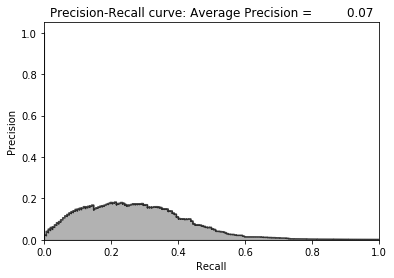

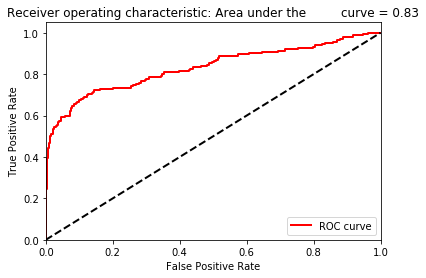

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 39s 203us/step - loss: 0.3136 - acc: 0.6373 - val_loss: 0.0827 - val_acc: 0.8779
Epoch 2/10
190820/190820 [==============================] - 30s 155us/step - loss: 0.1839 - acc: 0.7141 - val_loss: 0.0618 - val_acc: 0.8927
Epoch 3/10
190820/190820 [==============================] - 29s 151us/step - loss: 0.1654 - acc: 0.7203 - val_loss: 0.0525 - val_acc: 0.8991
Epoch 4/10
190820/190820 [==============================] - 28s 146us/step - loss: 0.1564 - acc: 0.7242 - val_loss: 0.0446 - val_acc: 0.9055
Epoch 5/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.1494 - acc: 0.7283 - val_loss: 0.0414 - val_acc: 0.9082
Epoch 6/10
190820/190820 [==============================] - 29s 152us/step - loss: 0.1444 - acc: 0.7300 - val_loss: 0.0474 - val_acc: 0.8958
Epoch 7/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1405 - acc: 0.731

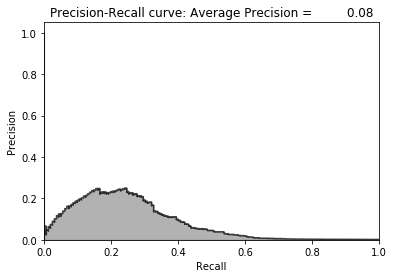

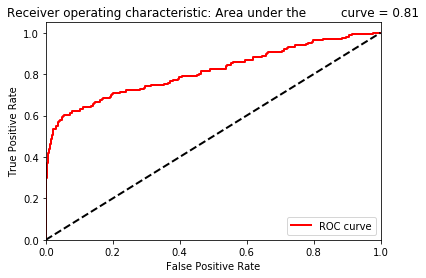

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 35s 184us/step - loss: 0.2989 - acc: 0.6441 - val_loss: 0.0825 - val_acc: 0.8787
Epoch 2/10
190820/190820 [==============================] - 28s 144us/step - loss: 0.1811 - acc: 0.7143 - val_loss: 0.0595 - val_acc: 0.8968
Epoch 3/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1620 - acc: 0.7233 - val_loss: 0.0496 - val_acc: 0.8975
Epoch 4/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1533 - acc: 0.7248 - val_loss: 0.0446 - val_acc: 0.8993
Epoch 5/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1480 - acc: 0.7257 - val_loss: 0.0403 - val_acc: 0.9009
Epoch 6/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1453 - acc: 0.7279 - val_loss: 0.0398 - val_acc: 0.8992
Epoch 7/10
190820/190820 [==============================] - 27s 141us/step - loss: 0.1424 - acc: 0.726

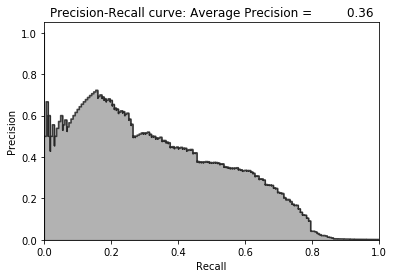

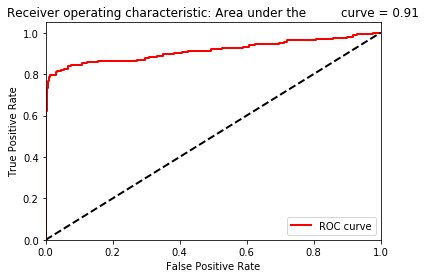

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 34s 178us/step - loss: 0.3128 - acc: 0.6370 - val_loss: 0.0874 - val_acc: 0.8747
Epoch 2/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1843 - acc: 0.7133 - val_loss: 0.0650 - val_acc: 0.8869
Epoch 3/10
190820/190820 [==============================] - 28s 147us/step - loss: 0.1643 - acc: 0.7219 - val_loss: 0.0513 - val_acc: 0.9060
Epoch 4/10
190820/190820 [==============================] - 28s 145us/step - loss: 0.1565 - acc: 0.7254 - val_loss: 0.0462 - val_acc: 0.8979
Epoch 5/10
190820/190820 [==============================] - 27s 142us/step - loss: 0.1509 - acc: 0.7270 - val_loss: 0.0428 - val_acc: 0.9011
Epoch 6/10
190820/190820 [==============================] - 27s 143us/step - loss: 0.1456 - acc: 0.7265 - val_loss: 0.0386 - val_acc: 0.9084
Epoch 7/10
190820/190820 [==============================] - 27s 140us/step - loss: 0.1438 - acc: 0.731

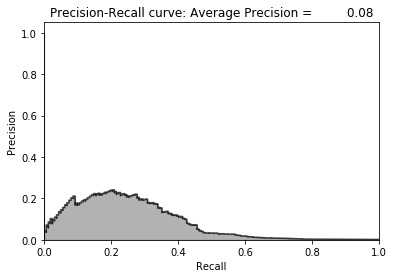

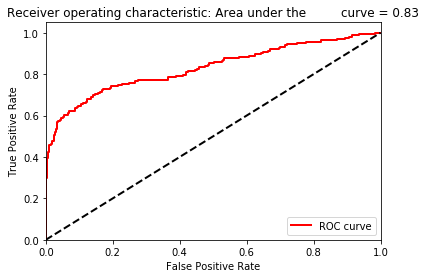

Mean average precision over 10 runs:  0.1284195585122149


[0.1267834060809368,
 0.06868310545917573,
 0.10488319381091678,
 0.08410542030005719,
 0.22614654088702085,
 0.08069506578314423,
 0.0715396440975446,
 0.08258712612341552,
 0.3551503170250595,
 0.08362176555487766]

In [33]:
# Model eleven
# Two layer denoising overcomplete autoencoder with ReLU activation
# And sparsity regularizer and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [34]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.1284195585122149
Coefficient of variation over 10 runs:  0.6818235764208924


[0.1267834060809368,
 0.06868310545917573,
 0.10488319381091678,
 0.08410542030005719,
 0.22614654088702085,
 0.08069506578314423,
 0.0715396440975446,
 0.08258712612341552,
 0.3551503170250595,
 0.08362176555487766]